# Identifying viral genome

In [ ]:
!pip install torchtnt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 2.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import numpy as np
import pandas as pd
import os

# torch library
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

# sklearn metrics
from sklearn.metrics import precision_score, recall_score, roc_curve, roc_auc_score, auc

# warnings
import warnings

# progression bar
from tqdm import tqdm

# plot library
import matplotlib.pyplot as plt

# hardware available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PROJECT_NAMES = []
sequence_length = 300
batch_size = 128
epochs = 30

## Data handling

### One-hot encoding DNA sequences

In [ ]:
# processes an entire dataset of DNA strings to onehot
def DNA_to_onehot_dataset(dataset):
    options_onehot = {'A': [1, 0, 0, 0, 0], 'C': [0, 1, 0, 0, 0], 'G': [0, 0, 1, 0, 0], 'T': [0, 0, 0.0, 1, 0],
                      'N': [0, 0, 0, 0, 1]}
    onehot_data = []
    for row in dataset:
        onehot_data.append([options_onehot[e] for e in row])
    onehot_data = torch.tensor(onehot_data, dtype=torch.float32)
    return onehot_data

In [ ]:
# processes a DNA string to onehot
def DNA_to_onehot(dna_line):
    options_onehot = {'A': [1, 0, 0, 0, 0], 'C': [0, 1, 0, 0, 0], 'G': [0, 0, 1, 0, 0], 'T': [0, 0, 0.0, 1, 0],
                      'N': [0, 0, 0, 0, 1]}
    onehot_data = [options_onehot[e] for e in dna_line]
    onehot_data = torch.tensor(onehot_data, dtype=torch.float32)
    return onehot_data

In [ ]:
# takes in a line from dataset in format "seq_ID,sequence,label"
# removes seq_ID, but remembers unique project names
def process_line(line):
    pieces = line.split(",")
    seq = pieces[1]
    label = float(pieces[2])

    proj = pieces[0][pieces[0].find("_"):].rstrip("1234567890")
    if proj not in PROJECT_NAMES:
        PROJECT_NAMES.append(proj)
    return seq, label

### Generating batches from the dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = []
        self.labels = []
        f = open(file_path)
        for line in f:
          line = line[:-1]  # remove \n
          seq, lab = process_line(line)
          self.data.append(DNA_to_onehot(seq))
          self.labels.append(lab)
        f.close()

    def __len__(self):
        # Return the total number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Generate one sample of data
        sample = self.data[idx]
        label = self.labels[idx]
        return sample, label

def generate_batches_from_file(file_path, batch_size):
    dataset = CustomDataset(file_path)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Load train data
train_loader = generate_batches_from_file('/content/drive/My Drive/datasets/fullset_train.csv', batch_size=batch_size)

# Load validation data
validation_loader = generate_batches_from_file('/content/drive/My Drive/datasets/fullset_validation.csv', batch_size=batch_size)

### Reading the datasets

In [ ]:
def read_dataset(path):
  seqs = []
  labels = []
  f = open(path)
  for line in f:
    line = line[:-1]  # remove \n
    seq, lab = process_line(line)
    seqs.append(DNA_to_onehot(seq))
    labels.append(lab)
  f.close()
  return seqs, labels

In [ ]:
# General paths
std_path = "/content/drive/My Drive/datasets/"
model_path = "/content/drive/My Drive/DeepLearningModels/"

# Dateset paths
dataset_train_path = std_path + "fullset_train.csv"
dataset_validation_path = std_path + "fullset_validation.csv"
dataset_test_path = std_path + "fullset_test.csv"

# Viraminer path models
save_path_frequency = std_path + "model_frequency"
save_path_pattern = std_path + "model_pattern"

# Train set size
train_set_size = len(open(dataset_train_path).readlines())
print("Train set size: ", train_set_size)

# Validation sequences and labels
val_seqs = torch.from_numpy(np.array(validation_loader.dataset.data)).float()
val_seqs.to(device)
val_labels = validation_loader.dataset.labels

# Test sequences and labels
test_seqs, test_labels = read_dataset(dataset_test_path)
test_set_size = len(test_labels)
print("Test set size:", test_set_size)
test_seqs = torch.from_numpy(np.array(test_seqs)).float()
test_labels = torch.from_numpy(np.array(test_labels)).float()

Train set size:  211239
Test set size: 26405


## Creating the Training pipeline

### Learning rate

In [ ]:
# Tested different learning rates for Viraminer model

# function to reduce learning rate
# def learning_rate_decay(epoch):
#     initial_learning_rate = 0.001
#     drop = 0.5
#     epochs_drop = 5.0
#     learning_rate = initial_learning_rate * np.power(drop, int((1 + epoch) / epochs_drop))
#     learning_rate = np.max([initial_learning_rate / 100, learning_rate])
#     print("Learning rate decay called: new learning rate: ", learning_rate)
#     return learning_rate

# test n.2: Exponential decay learning rate
# def learning_rate_decay(epoch):
#     initial_learning_rate = 0.001
#     decay_rate = 0.1
#     learning_rate = initial_learning_rate * np.exp(-decay_rate * epoch)
#     learning_rate = np.max([initial_learning_rate / 100, learning_rate])
#     print("Learning rate decay called: new learning rate: ", learning_rate)
#     return learning_rate


# test n.3: Exponential step decay learning rate
# def learning_rate_decay(epoch):
#     initial_learning_rate = 0.001
#     decay_rate = 0.1
#     drop = 0.5
#     epochs_drop = 2
#     steps = epoch // epochs_drop
#     base_learning_rate = initial_learning_rate * np.power(drop, steps)
#     learning_rate = base_learning_rate * np.exp(-decay_rate * (epoch % epochs_drop))
#     learning_rate = np.max([initial_learning_rate / 100, learning_rate])
#     print(f"Learning rate decay called: new learning rate for epoch {epoch}: {learning_rate}")
#     return learning_rate


# test n.4: Linear decay learning rate
# def learning_rate_decay(epoch):
#     initial_learning_rate = 0.001
#     decay_rate = 0.75
#     learning_rate = initial_learning_rate * (decay_rate ** epoch)
#     learning_rate = max(initial_learning_rate / 100, learning_rate)
#     print(f"Learning rate decay called: new learning rate for epoch {epoch}: {learning_rate}")
#     return learning_rate


# test n.5
# def learning_rate_decay(epoch):
#     return 0.0005

### Making predictions

In [ ]:
# function to take in a dataset and predict for each line
def predict_one_by_one(model, seqs, labels):
    prediction_data = np.empty([len(seqs), 4])  # true_class, pred_class, proba, seq_length
    for i, seq in enumerate(seqs):
        p = model.predict(np.expand_dims(seq, axis=0))
        prediction_data[i, 0] = labels[i]
        prediction_data[i, 1] = int(p > 0.5)
        prediction_data[i, 2] = p
        prediction_data[i, 3] = len(seq)
    return prediction_data

###Callbacks

In [ ]:
# Callback class definition

class Callback:
  def on_training_begin(self, logs=None):
    pass

  def on_epoch_begin(self, epoch, logs=None):
    pass

  def on_batch_begin(self, batch, logs=None):
    pass

  def on_batch_end(self, batch, logs=None):
    pass

  def on_epoch_end(self, epoch, logs=None):
    pass

  def on_train_end(self, logs=None):
    pass


In [ ]:
# Specialized AUROC callbacks

# Callback to printout VALIDATION AUROC on each epoch end
class roc_callback(Callback):
    """# Arguments
       validation_data: validation data in format (val_x,val_y)
    """

    def __init__(self, model, validation_data):
      self.x_val = validation_data[0]
      self.y_val = validation_data[1]
      self.model = model
      global batch_size

    def on_epoch_end(self, epoch, logs=None):
      self.model.eval()
      y_true = self.y_val
      y_pred = []

      with torch.no_grad():
        for i in range(0, len(self.x_val), batch_size):
          batch_x = self.x_val[i:i+batch_size].to(device)
          batch_pred = self.model(batch_x).cpu().numpy()
          y_pred.extend(batch_pred)

      y_pred = np.array(y_pred)
      roc_val = roc_auc_score(y_true, y_pred)

      print((" AUROC on Validation: ", str(round(roc_val, 4))))
      if roc_val == 0.5:  # happens if learning has crashed
        self.model.stop_training = True
        print("ATTENTION: Stopped learning process, because learning had in all probability crashed!")
      self.model.train()

In [ ]:
# The following Callback allows to only save best models according to VAL AUROC
# Adapted from default ModelCheckpoint code
class ModelCheckpointAUROC(Callback):
    """Save the model after every epoch.
    `filepath` can contain named formatting options,
    which will be filled with the values of `epoch` and
    keys in `logs` (passed in `on_epoch_end`).
    For example: if `filepath` is `weights.{epoch:02d}-{val_loss:.2f}.hdf5`,
    then the model checkpoints will be saved with the epoch number and
    the validation loss in the filename.
    # Arguments
        filepath: string, path to save the model file.
        validation_data: (NEWLY ADDED for AUROC calculation - validation
            data in format (val_x,val_y)
        verbose: verbosity mode, 0 or 1.
        save_best_only: if `save_best_only=True`,
            the latest best model according to
            the quantity monitored will not be overwritten.
        save_weights_only: if True, then only the model's weights will be
            saved (`model.save_weights(filepath)`), else the full model
            is saved (`model.save(filepath)`).
        period: Interval (number of epochs) between checkpoints.
    """

    def __init__(self, model, filepath, validation_data, verbose=0,
                 save_best_only=False, save_weights_only=False,
                 period=1):
        super(ModelCheckpointAUROC, self).__init__()

        # added these two
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

        self.model = model
        global batch_size

        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0

        # AUROC - the more the better
        self.monitor_op = np.greater
        self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        # calculate AUROC
        self.model.eval()

        y_pred_val = []

        with torch.no_grad():
            for i in range(0, len(self.x_val), batch_size):
                batch_x = self.x_val[i:i+batch_size].to(device)
                batch_pred = self.model(batch_x).cpu().numpy()
                y_pred_val.extend(batch_pred)

        y_pred_val = np.array(y_pred_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)

        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            if self.save_best_only:
                current = roc_val
                if current is None:
                    warnings.warn('Can save best model. Current area_under_ROC is None.'
                                  'skipping.', RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print(('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                   ' saving model to %s'
                                   % (epoch + 1, "AUROC", self.best,
                                      current, filepath)))
                        self.best = current
                        if self.save_weights_only:
                            torch.save(self.model.state_dict(), filepath)
                        else:
                            torch.save(self.model.state_dict(), filepath)
                    else:
                        if self.verbose > 0:
                            print(('\nEpoch %05d: %s did not improve from %0.5f (current: %0.5f)' %
                                   (epoch + 1, "AUROC", self.best, current)))
            else:
                if self.verbose > 0:
                    print(('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath)))
                if self.save_weights_only:
                    torch.save(self.model.state_dict(), filepath)
                else:
                    torch.save(self.model, filepath)

In [ ]:
# The following Callback allows to stop learning if VAL AUROC is not improving.
# Adapted from default EarlyStopping Code.
class EarlyStoppingAUROC(Callback):
    """Stop training when a monitored quantity has stopped improving.
    # Arguments
        validation_data: (NEWLY ADDED for AUROC calculation) validation
            data in format (val_x,val_y)
        min_delta: minimum change in the monitored quantity
            to qualify as an improvement, i.e. an absolute
            change of less than min_delta, will count as no
            improvement.
        patience: number of epochs with no improvement
            after which training will be stopped.
        verbose: verbosity mode.
        baseline: Baseline value for the monitored quantity to reach.
            Training will stop if the model doesn't show improvement
            over the baseline.
        restore_best_weights: whether to restore model weights from
            the epoch with the best value of the monitored quantity.
            If False, the model weights obtained at the last step of
            training are used.
    """

    # added validation data as input to the callback
    def __init__(self, model, validation_data,
                 min_delta=0,
                 patience=0,
                 verbose=0,
                 baseline=None,
                 restore_best_weights=False):
        super(EarlyStoppingAUROC, self).__init__()

        global batch_size

        self.model = model
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]

        self.baseline = baseline
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = -np.Inf

        # Can hardcode these as metric is defined to be AUROC
        self.monitor_op = np.greater
        self.min_delta *= 1

    def on_training_begin(self, logs=None):
        # Allow instances to be re-used
        self.wait = 0
        self.stopped_epoch = 0
        if self.baseline is not None:
            self.best = self.baseline
            print("self best", self.best)
        else:
            self.best = np.Inf if self.monitor_op == np.less else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        # Added AUROC calculation
        self.model.eval()

        y_pred_val = []

        with torch.no_grad():
            for i in range(0, len(self.x_val), batch_size):
                batch_x = self.x_val[i:i+batch_size].to(device)
                batch_pred = self.model(batch_x).cpu().numpy()
                y_pred_val.extend(batch_pred)

        y_pred_val = np.array(y_pred_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)

        current = roc_val  # everything below is unchanged
        if current is None:
            return

        if self.monitor_op(current - self.min_delta, self.best):
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.state_dict()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    if self.verbose > 0:
                        print('Restoring model weights from the end of '
                              'the best epoch')
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print(('Epoch %05d: early stopping' % (self.stopped_epoch + 1)))

In [ ]:
class LearningRateScheduler(Callback):
    def __init__(self, schedule, model, optimizer):
        super(LearningRateScheduler, self).__init__()
        self.schedule = schedule
        self.model = model
        self.optimizer = optimizer

    def on_epoch_begin(self, epoch, logs=None):
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=2)
        print(f'\nEpoch {epoch + 1}: Learning rate is {float(self.schedule(epoch)):.6f}')

def learning_rate_decay(epoch, initial_lr=0.01, decay_rate=0.9, decay_steps=1):
    return initial_lr * (decay_rate ** (epoch // decay_steps))

In [ ]:
# Callbacks creation method

def create_callbacks(model, optimizer, save_path, val_seqs, val_labels):
    callbacks = []
    val_seqs.to(device)
    callbacks.append(
        ModelCheckpointAUROC(model, filepath=save_path + ".pt", validation_data=(val_seqs, val_labels), verbose=1,
                            save_best_only=True))
    callbacks.append(EarlyStoppingAUROC(model, validation_data=(val_seqs, val_labels), patience=6, min_delta=0.001))
    callbacks.append(roc_callback(model, validation_data=(val_seqs, val_labels)))
    callbacks.append(LearningRateScheduler(learning_rate_decay, model, optimizer))
    return callbacks

### Training function

In [ ]:
# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, callbacks=None):
    model.to(device)

    # Callbacks (if any)
    if callbacks:
        for callback in callbacks:
            callback.on_training_begin()


    for i in tqdm(range(num_epochs), desc="Processing"):
        #for epoch in range(num_epochs): # no progression bar version
        running_loss = 0.0
        model.train()

        if callbacks:
            for callback in callbacks:
                callback.on_epoch_begin(i)

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs.float())
            labels = labels.unsqueeze(1).float()
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)  # Move to GPU
                val_labels = val_labels.to(torch.float)
                val_outputs = model(val_inputs)
                # print("Val_output evaluation: ", val_outputs) # See results
                v_loss = criterion(val_outputs, val_labels.unsqueeze(1))
                val_loss += v_loss.item()

        # Print statistics
        print(f"Epoch [{i+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

        # Callbacks (if any)
        if callbacks:
            for callback in callbacks:
                callback.on_epoch_end(i, logs={'loss': running_loss/len(train_loader), 'val_loss': val_loss/len(val_loader)})

In [ ]:
# Definition of GloabalAveragePooling (not present in pytorch)
class GlobalAveragePooling1D(nn.Module):
    def __init__(self):
        super(GlobalAveragePooling1D, self).__init__()

    def forward(self, x):
        # x should have shape (batch_size, channels, seq_length)
        return F.adaptive_avg_pool1d(x, 1).squeeze(-1)

class GlobalMaxPooling1D(nn.Module):
    def __init__(self):
        super(GlobalMaxPooling1D, self).__init__()

    def forward(self, x):
        # x should have shape (batch_size, channels, seq_length)
        return F.adaptive_max_pool1d(x, 1).squeeze(-1)

## Models and Training

### ViraMiner

#### Frequency branch

In [ ]:
# Define the PyTorch model class
class FrequencyBranch(nn.Module):
    def __init__(self, sequence_length, layer_sizes, filter_size, dropout):
        super(FrequencyBranch, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=layer_sizes, kernel_size=filter_size)
        self.global_avg_pool = GlobalAveragePooling1D()
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(layer_sizes, layer_sizes)
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(layer_sizes, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, sequence_length, 5) to (batch_size, 5, sequence_length)
        x = F.relu(self.conv1(x))
        x = self.global_avg_pool.forward(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Function to build the PyTorch model
def build_frequency_branch(sequence_length, layer_sizes, filter_size, dropout, learning_rate):
    model = FrequencyBranch(sequence_length, layer_sizes, filter_size, dropout)

    # Define the loss function and the optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # Alternatively, SGD version:
    # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Print the model summary
    print(model)

    return model, criterion, optimizer

In [ ]:
save_path_frequency = std_path + "model_frequency"

frequency_model, criterion, optimizer = build_frequency_branch(300, 1000, 8, 0.1, 0.001)
frequency_model.to(device)

callbacks_frequency = create_callbacks(frequency_model, optimizer, save_path_frequency, val_seqs, val_labels)
train_model(frequency_model, criterion, optimizer, train_loader, validation_loader, epochs, callbacks_frequency)

torch.save(frequency_model.state_dict(), std_path + 'frequency_model.pth')


FrequencyBranch(
  (conv1): Conv1d(5, 1000, kernel_size=(8,), stride=(1,))
  (global_avg_pool): GlobalAveragePooling1D()
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=1000, out_features=1000, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
)


Processing:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Learning rate is 0.010000
Epoch [1/30], Loss: 0.1005, Val Loss: 0.0931

Epoch 00001: AUROC improved from -inf to 0.78431, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:   3%|▎         | 1/30 [00:25<12:13, 25.28s/it]

(' AUROC on Validation: ', '0.7843')

Epoch 2: Learning rate is 0.009000
Epoch [2/30], Loss: 0.0905, Val Loss: 0.0876

Epoch 00002: AUROC improved from 0.78431 to 0.82071, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:   7%|▋         | 2/30 [00:49<11:22, 24.37s/it]

(' AUROC on Validation: ', '0.8207')

Epoch 3: Learning rate is 0.008100
Epoch [3/30], Loss: 0.0864, Val Loss: 0.0850

Epoch 00003: AUROC improved from 0.82071 to 0.83357, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  10%|█         | 3/30 [01:12<10:49, 24.05s/it]

(' AUROC on Validation: ', '0.8336')

Epoch 4: Learning rate is 0.007290
Epoch [4/30], Loss: 0.0839, Val Loss: 0.0832

Epoch 00004: AUROC improved from 0.83357 to 0.85130, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  13%|█▎        | 4/30 [01:36<10:21, 23.91s/it]

(' AUROC on Validation: ', '0.8513')

Epoch 5: Learning rate is 0.006561
Epoch [5/30], Loss: 0.0816, Val Loss: 0.0776

Epoch 00005: AUROC improved from 0.85130 to 0.85893, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  17%|█▋        | 5/30 [02:00<09:56, 23.86s/it]

(' AUROC on Validation: ', '0.8589')

Epoch 6: Learning rate is 0.005905
Epoch [6/30], Loss: 0.0787, Val Loss: 0.0757

Epoch 00006: AUROC improved from 0.85893 to 0.87137, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  20%|██        | 6/30 [02:23<09:31, 23.82s/it]

(' AUROC on Validation: ', '0.8714')

Epoch 7: Learning rate is 0.005314
Epoch [7/30], Loss: 0.0762, Val Loss: 0.0732

Epoch 00007: AUROC improved from 0.87137 to 0.87904, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  23%|██▎       | 7/30 [02:47<09:07, 23.78s/it]

(' AUROC on Validation: ', '0.879')

Epoch 8: Learning rate is 0.004783
Epoch [8/30], Loss: 0.0736, Val Loss: 0.0713

Epoch 00008: AUROC improved from 0.87904 to 0.87970, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  27%|██▋       | 8/30 [03:11<08:42, 23.76s/it]

(' AUROC on Validation: ', '0.8797')

Epoch 9: Learning rate is 0.004305
Epoch [9/30], Loss: 0.0716, Val Loss: 0.0705

Epoch 00009: AUROC improved from 0.87970 to 0.88524, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  30%|███       | 9/30 [03:35<08:18, 23.76s/it]

(' AUROC on Validation: ', '0.8852')

Epoch 10: Learning rate is 0.003874
Epoch [10/30], Loss: 0.0699, Val Loss: 0.0772

Epoch 00010: AUROC improved from 0.88524 to 0.88722, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  33%|███▎      | 10/30 [03:58<07:54, 23.75s/it]

(' AUROC on Validation: ', '0.8872')

Epoch 11: Learning rate is 0.003487
Epoch [11/30], Loss: 0.0680, Val Loss: 0.0708

Epoch 00011: AUROC improved from 0.88722 to 0.89239, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  37%|███▋      | 11/30 [04:22<07:30, 23.74s/it]

(' AUROC on Validation: ', '0.8924')

Epoch 12: Learning rate is 0.003138
Epoch [12/30], Loss: 0.0663, Val Loss: 0.0685

Epoch 00012: AUROC improved from 0.89239 to 0.89268, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  40%|████      | 12/30 [04:46<07:06, 23.72s/it]

(' AUROC on Validation: ', '0.8927')

Epoch 13: Learning rate is 0.002824
Epoch [13/30], Loss: 0.0649, Val Loss: 0.0669

Epoch 00013: AUROC did not improve from 0.89268 (current: 0.89102)


Processing:  43%|████▎     | 13/30 [05:09<06:42, 23.70s/it]

(' AUROC on Validation: ', '0.891')

Epoch 14: Learning rate is 0.002542
Epoch [14/30], Loss: 0.0638, Val Loss: 0.0675

Epoch 00014: AUROC did not improve from 0.89268 (current: 0.89250)


Processing:  47%|████▋     | 14/30 [05:33<06:19, 23.69s/it]

(' AUROC on Validation: ', '0.8925')

Epoch 15: Learning rate is 0.002288
Epoch [15/30], Loss: 0.0622, Val Loss: 0.0679

Epoch 00015: AUROC improved from 0.89268 to 0.89457, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  50%|█████     | 15/30 [05:57<05:55, 23.69s/it]

(' AUROC on Validation: ', '0.8946')

Epoch 16: Learning rate is 0.002059
Epoch [16/30], Loss: 0.0606, Val Loss: 0.0662

Epoch 00016: AUROC improved from 0.89457 to 0.89725, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  53%|█████▎    | 16/30 [06:20<05:31, 23.70s/it]

(' AUROC on Validation: ', '0.8972')

Epoch 17: Learning rate is 0.001853
Epoch [17/30], Loss: 0.0594, Val Loss: 0.0656

Epoch 00017: AUROC improved from 0.89725 to 0.90174, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  57%|█████▋    | 17/30 [06:44<05:08, 23.69s/it]

(' AUROC on Validation: ', '0.9017')

Epoch 18: Learning rate is 0.001668
Epoch [18/30], Loss: 0.0584, Val Loss: 0.0647

Epoch 00018: AUROC did not improve from 0.90174 (current: 0.89959)


Processing:  60%|██████    | 18/30 [07:08<04:44, 23.70s/it]

(' AUROC on Validation: ', '0.8996')

Epoch 19: Learning rate is 0.001501
Epoch [19/30], Loss: 0.0570, Val Loss: 0.0672

Epoch 00019: AUROC did not improve from 0.90174 (current: 0.90001)


Processing:  63%|██████▎   | 19/30 [07:32<04:20, 23.70s/it]

(' AUROC on Validation: ', '0.9')

Epoch 20: Learning rate is 0.001351
Epoch [20/30], Loss: 0.0557, Val Loss: 0.0661

Epoch 00020: AUROC did not improve from 0.90174 (current: 0.89410)


Processing:  67%|██████▋   | 20/30 [07:55<03:56, 23.69s/it]

(' AUROC on Validation: ', '0.8941')

Epoch 21: Learning rate is 0.001216
Epoch [21/30], Loss: 0.0550, Val Loss: 0.0641

Epoch 00021: AUROC improved from 0.90174 to 0.90685, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  70%|███████   | 21/30 [08:19<03:33, 23.68s/it]

(' AUROC on Validation: ', '0.9068')

Epoch 22: Learning rate is 0.001094
Epoch [22/30], Loss: 0.0536, Val Loss: 0.0662

Epoch 00022: AUROC improved from 0.90685 to 0.90687, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  73%|███████▎  | 22/30 [08:43<03:09, 23.69s/it]

(' AUROC on Validation: ', '0.9069')

Epoch 23: Learning rate is 0.000985
Epoch [23/30], Loss: 0.0520, Val Loss: 0.0661

Epoch 00023: AUROC did not improve from 0.90687 (current: 0.90418)


Processing:  77%|███████▋  | 23/30 [09:06<02:45, 23.68s/it]

(' AUROC on Validation: ', '0.9042')

Epoch 24: Learning rate is 0.000886
Epoch [24/30], Loss: 0.0513, Val Loss: 0.0656

Epoch 00024: AUROC did not improve from 0.90687 (current: 0.90513)


Processing:  80%|████████  | 24/30 [09:30<02:22, 23.67s/it]

(' AUROC on Validation: ', '0.9051')

Epoch 25: Learning rate is 0.000798
Epoch [25/30], Loss: 0.0503, Val Loss: 0.0649

Epoch 00025: AUROC improved from 0.90687 to 0.90712, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  83%|████████▎ | 25/30 [09:54<01:58, 23.68s/it]

(' AUROC on Validation: ', '0.9071')

Epoch 26: Learning rate is 0.000718
Epoch [26/30], Loss: 0.0491, Val Loss: 0.0663

Epoch 00026: AUROC improved from 0.90712 to 0.90814, saving model to /content/drive/My Drive/datasets/model_frequency.pt


Processing:  87%|████████▋ | 26/30 [10:17<01:34, 23.70s/it]

(' AUROC on Validation: ', '0.9081')

Epoch 27: Learning rate is 0.000646
Epoch [27/30], Loss: 0.0484, Val Loss: 0.0652

Epoch 00027: AUROC did not improve from 0.90814 (current: 0.90759)


Processing:  90%|█████████ | 27/30 [10:41<01:11, 23.69s/it]

(' AUROC on Validation: ', '0.9076')

Epoch 28: Learning rate is 0.000581
Epoch [28/30], Loss: 0.0478, Val Loss: 0.0670

Epoch 00028: AUROC did not improve from 0.90814 (current: 0.90322)


Processing:  93%|█████████▎| 28/30 [11:05<00:47, 23.69s/it]

(' AUROC on Validation: ', '0.9032')

Epoch 29: Learning rate is 0.000523
Epoch [29/30], Loss: 0.0466, Val Loss: 0.0636

Epoch 00029: AUROC did not improve from 0.90814 (current: 0.90643)


Processing:  97%|█████████▋| 29/30 [11:28<00:23, 23.70s/it]

(' AUROC on Validation: ', '0.9064')

Epoch 30: Learning rate is 0.000471
Epoch [30/30], Loss: 0.0454, Val Loss: 0.0696

Epoch 00030: AUROC did not improve from 0.90814 (current: 0.90506)


Processing: 100%|██████████| 30/30 [11:52<00:00, 23.75s/it]

(' AUROC on Validation: ', '0.9051')


#### Pattern branch

In [ ]:
# Define the PyTorch model class
class PatternBranch(nn.Module):
    def __init__(self, sequence_length, layer_sizes, filter_size, dropout):
        super(PatternBranch, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=layer_sizes, kernel_size=filter_size)
        self.global_max_pool = GlobalMaxPooling1D()
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(layer_sizes, layer_sizes)
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(layer_sizes, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, sequence_length, 5) to (batch_size, 5, sequence_length)
        x = F.relu(self.conv1(x))
        x = self.global_max_pool.forward(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc2(x))
        print(x.shape)
        return x

# Function to build the PyTorch model
def build_pattern_branch(sequence_length, layer_sizes, filter_size, dropout, learning_rate):
    model = PatternBranch(sequence_length, layer_sizes, filter_size, dropout)

    # Define the loss function and the optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # Alternatively, SGD version:
    # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Print the model summary
    print(model)

    return model, criterion, optimizer

In [ ]:

save_path_pattern = std_path + "model_pattern"

pattern_model, criterion, optimizer = build_pattern_branch(300, 1200, 11, 0.1, 0.001)
pattern_model.to(device)

callbacks_pattern = create_callbacks(pattern_model, optimizer, save_path_pattern, val_seqs, val_labels)
train_model(pattern_model, criterion, optimizer, train_loader, validation_loader, epochs, callbacks_pattern)

torch.save(pattern_model.state_dict(), std_path + 'pattern_model.pth')

PatternBranch(
  (conv1): Conv1d(5, 1200, kernel_size=(11,), stride=(1,))
  (global_max_pool): GlobalMaxPooling1D()
  (dropout1): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=1200, out_features=1200, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=1200, out_features=1, bias=True)
)


Processing:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Learning rate is 0.010000
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1]

Processing:   3%|▎         | 1/30 [00:32<15:43, 32.53s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8436')

Epoch 2: Learning rate is 0.009000
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torc

Processing:   7%|▋         | 2/30 [01:04<15:09, 32.48s/it]

(' AUROC on Validation: ', '0.8716')

Epoch 3: Learning rate is 0.008100
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  10%|█         | 3/30 [01:37<14:36, 32.46s/it]

(' AUROC on Validation: ', '0.8766')

Epoch 4: Learning rate is 0.007290
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  13%|█▎        | 4/30 [02:09<14:03, 32.43s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8828')

Epoch 5: Learning rate is 0.006561
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torc

Processing:  17%|█▋        | 5/30 [02:42<13:30, 32.42s/it]

torch.Size([37, 1])
(' AUROC on Validation: ', '0.8871')

Epoch 6: Learning rate is 0.005905
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torc

Processing:  20%|██        | 6/30 [03:14<12:57, 32.41s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8884')

Epoch 7: Learning rate is 0.005314
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torc

Processing:  23%|██▎       | 7/30 [03:46<12:25, 32.41s/it]

(' AUROC on Validation: ', '0.8827')

Epoch 8: Learning rate is 0.004783
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  27%|██▋       | 8/30 [04:19<11:53, 32.41s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8877')

Epoch 9: Learning rate is 0.004305
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torc

Processing:  30%|███       | 9/30 [04:51<11:20, 32.41s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.883')

Epoch 10: Learning rate is 0.003874
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torc

Processing:  33%|███▎      | 10/30 [05:24<10:47, 32.40s/it]

(' AUROC on Validation: ', '0.8862')

Epoch 11: Learning rate is 0.003487
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
to

Processing:  37%|███▋      | 11/30 [05:56<10:15, 32.40s/it]

(' AUROC on Validation: ', '0.8877')

Epoch 12: Learning rate is 0.003138
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
to

Processing:  40%|████      | 12/30 [06:29<09:43, 32.41s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8888')

Epoch 13: Learning rate is 0.002824
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  43%|████▎     | 13/30 [07:01<09:10, 32.41s/it]

torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8841')

Epoch 14: Learning rate is 0.002542
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  47%|████▋     | 14/30 [07:33<08:38, 32.41s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8852')

Epoch 15: Learning rate is 0.002288
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  50%|█████     | 15/30 [08:06<08:06, 32.41s/it]

torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8813')

Epoch 16: Learning rate is 0.002059
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  53%|█████▎    | 16/30 [08:38<07:33, 32.41s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8834')

Epoch 17: Learning rate is 0.001853
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  57%|█████▋    | 17/30 [09:11<07:01, 32.39s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8865')

Epoch 18: Learning rate is 0.001668
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  60%|██████    | 18/30 [09:43<06:28, 32.39s/it]

(' AUROC on Validation: ', '0.8815')

Epoch 19: Learning rate is 0.001501
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
to

Processing:  63%|██████▎   | 19/30 [10:15<05:56, 32.38s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8832')

Epoch 20: Learning rate is 0.001351
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  67%|██████▋   | 20/30 [10:48<05:23, 32.38s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8814')

Epoch 21: Learning rate is 0.001216
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  70%|███████   | 21/30 [11:20<04:51, 32.38s/it]

(' AUROC on Validation: ', '0.8881')

Epoch 22: Learning rate is 0.001094
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
to

Processing:  73%|███████▎  | 22/30 [11:52<04:19, 32.38s/it]

torch.Size([37, 1])
(' AUROC on Validation: ', '0.8842')

Epoch 23: Learning rate is 0.000985
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  77%|███████▋  | 23/30 [12:25<03:46, 32.40s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8736')

Epoch 24: Learning rate is 0.000886
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  80%|████████  | 24/30 [12:57<03:14, 32.40s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8768')

Epoch 25: Learning rate is 0.000798
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  83%|████████▎ | 25/30 [13:30<02:41, 32.39s/it]

(' AUROC on Validation: ', '0.8831')

Epoch 26: Learning rate is 0.000718
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
to

Processing:  87%|████████▋ | 26/30 [14:02<02:09, 32.38s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8768')

Epoch 27: Learning rate is 0.000646
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  90%|█████████ | 27/30 [14:34<01:37, 32.39s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8706')

Epoch 28: Learning rate is 0.000581
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing:  93%|█████████▎| 28/30 [15:07<01:04, 32.39s/it]

(' AUROC on Validation: ', '0.8755')

Epoch 29: Learning rate is 0.000523
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
to

Processing:  97%|█████████▋| 29/30 [15:39<00:32, 32.38s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8802')

Epoch 30: Learning rate is 0.000471
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
tor

Processing: 100%|██████████| 30/30 [16:12<00:00, 32.40s/it]

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([37, 1])
(' AUROC on Validation: ', '0.8737')


### GRU

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, sequence_length, layer_sizes, dropout, learning_rate):
        super(GRUModel, self).__init__()
        self.sequence_length = sequence_length
        self.layer_sizes = layer_sizes
        self.dropout = dropout

        self.bigru1 = nn.GRU(input_size=5, hidden_size=128, num_layers=1, bidirectional=False, batch_first=True)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(dropout)


        self.dense1 = nn.Linear(128, layer_sizes)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.dense_dropout = nn.Dropout(dropout)
        self.output = nn.Linear(layer_sizes, 1)

        self.learning_rate = learning_rate

    def forward(self, x):

        x, _ = self.bigru1(x)
        x = x.transpose(1, 2)  # Swap seq_length and hidden_size dimensions
        x = self.batch_norm1(x)
        x = x.transpose(1, 2)  # Swap back to original shape
        x = self.dropout1(x)

        x = self.global_max_pool(x.transpose(1, 2)).squeeze(-1)  # Global max pooling
        x = F.relu(self.dense1(x))
        x = self.dense_dropout(x)
        x = torch.sigmoid(self.output(x))
        return x


# Function to build the PyTorch model
def build_GRUModel_model(sequence_length, layer_sizes, dropout, learning_rate):
    model = GRUModel(sequence_length, layer_sizes, dropout, learning_rate)

    # Define the loss function and the optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # Alternatively, if you want to use SGD:
    # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Print the model summary
    # summary(model, input_size=(sequence_length, 5))
    print(model)

    return model, criterion, optimizer

In [ ]:
save_path_gru = std_path + "model_gru"

GRU_model, criterion, optimizer = build_GRUModel_model(300, 1200, 0.5, 0.001)
GRU_model.to(device)

callbacks_GRU = create_callbacks(GRU_model, optimizer, save_path_gru, val_seqs, val_labels)
train_model(GRU_model, criterion, optimizer, train_loader, validation_loader, epochs, callbacks_GRU)

torch.save(GRU_model.state_dict(), std_path + 'GRU_model.pth')

### Bi-GRU

In [ ]:
class BiGRUModel(nn.Module):
    def __init__(self, sequence_length, layer_sizes, dropout, learning_rate):
        super(BiGRUModel, self).__init__()
        self.sequence_length = sequence_length
        self.layer_sizes = layer_sizes
        self.dropout = dropout

        self.bigru1 = nn.GRU(input_size=5, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.batch_norm1 = nn.BatchNorm1d(sequence_length)
        self.dropout1 = nn.Dropout(dropout)

        self.dense1 = nn.Linear(128, layer_sizes)
        self.dense_dropout = nn.Dropout(dropout)
        self.output = nn.Linear(layer_sizes, 1)

        self.learning_rate = learning_rate

    def forward(self, x):
        x, _ = self.bigru1(x)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x, _ = torch.max(x, 1) # reduced sequence dimension

        x = F.relu(self.dense1(x))
        x = self.dense_dropout(x)
        x = torch.sigmoid(self.output(x))
        return x



# Function to build the PyTorch model
def build_BiGRU_model(sequence_length, layer_sizes, dropout, learning_rate):
    model = BiGRUModel(sequence_length, layer_sizes, dropout, learning_rate)

    # Define the loss function and the optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # Alternatively, SGD version:
    # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Print the model summary
    # summary(model, input_size=(sequence_length, 5))
    print(model)

    return model, criterion, optimizer

# Function to build the PyTorch model
def build_BiGRU_model(sequence_length, layer_sizes, dropout, learning_rate):
    model = BiGRUModel(sequence_length, layer_sizes, dropout, learning_rate)

    # Define the loss function and the optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # Alternatively, SGD version:
    # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Print the model summary
    # summary(model, input_size=(sequence_length, 5))
    print(model)

    return model, criterion, optimizer

In [ ]:
save_path_bi_gru = std_path + "model_bi_gru"

Bi_GRU_model, criterion, optimizer = build_BiGRU_model(300, 1200, 0.5, 0.001)
Bi_GRU_model.to(device)

callbacks_bi_GRU = create_callbacks(Bi_GRU_model, optimizer, save_path_bi_gru, val_seqs, val_labels)

train_model(Bi_GRU_model, criterion, optimizer, train_loader, validation_loader, epochs, callbacks_bi_GRU)
torch.save(Bi_GRU_model.state_dict(), std_path + 'Bi_GRU_model.pth')


BiGRUModel(
  (bigru1): GRU(5, 64, batch_first=True, bidirectional=True)
  (batch_norm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=128, out_features=1200, bias=True)
  (dense_dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=1200, out_features=1, bias=True)
)


Processing:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Learning rate is 0.010000
Epoch [1/30], Loss: 0.1049, Val Loss: 0.1775

Epoch 00001: AUROC improved from -inf to 0.66064, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:   3%|▎         | 1/30 [00:18<09:05, 18.81s/it]

(' AUROC on Validation: ', '0.6606')

Epoch 2: Learning rate is 0.009000
Epoch [2/30], Loss: 0.1028, Val Loss: 0.1787

Epoch 00002: AUROC improved from 0.66064 to 0.66956, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:   7%|▋         | 2/30 [00:37<08:46, 18.80s/it]

(' AUROC on Validation: ', '0.6696')

Epoch 3: Learning rate is 0.008100
Epoch [3/30], Loss: 0.1020, Val Loss: 0.1473

Epoch 00003: AUROC did not improve from 0.66956 (current: 0.66812)


Processing:  10%|█         | 3/30 [00:55<08:18, 18.46s/it]

(' AUROC on Validation: ', '0.6681')

Epoch 4: Learning rate is 0.007290
Epoch [4/30], Loss: 0.1014, Val Loss: 0.1542

Epoch 00004: AUROC improved from 0.66956 to 0.68661, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  13%|█▎        | 4/30 [01:14<08:02, 18.55s/it]

(' AUROC on Validation: ', '0.6866')

Epoch 5: Learning rate is 0.006561
Epoch [5/30], Loss: 0.1004, Val Loss: 0.1460

Epoch 00005: AUROC improved from 0.68661 to 0.72694, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  17%|█▋        | 5/30 [01:32<07:42, 18.49s/it]

(' AUROC on Validation: ', '0.7269')

Epoch 6: Learning rate is 0.005905
Epoch [6/30], Loss: 0.0955, Val Loss: 0.2253

Epoch 00006: AUROC improved from 0.72694 to 0.77169, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  20%|██        | 6/30 [01:51<07:28, 18.68s/it]

(' AUROC on Validation: ', '0.7717')

Epoch 7: Learning rate is 0.005314
Epoch [7/30], Loss: 0.0927, Val Loss: 0.1378

Epoch 00007: AUROC improved from 0.77169 to 0.78195, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  23%|██▎       | 7/30 [02:10<07:07, 18.60s/it]

(' AUROC on Validation: ', '0.782')

Epoch 8: Learning rate is 0.004783
Epoch [8/30], Loss: 0.0913, Val Loss: 0.1675

Epoch 00008: AUROC improved from 0.78195 to 0.80239, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  27%|██▋       | 8/30 [02:28<06:45, 18.43s/it]

(' AUROC on Validation: ', '0.8024')

Epoch 9: Learning rate is 0.004305
Epoch [9/30], Loss: 0.0894, Val Loss: 0.1355

Epoch 00009: AUROC improved from 0.80239 to 0.81302, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  30%|███       | 9/30 [02:46<06:24, 18.32s/it]

(' AUROC on Validation: ', '0.813')

Epoch 10: Learning rate is 0.003874
Epoch [10/30], Loss: 0.0881, Val Loss: 0.1223

Epoch 00010: AUROC improved from 0.81302 to 0.81555, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  33%|███▎      | 10/30 [03:04<06:07, 18.35s/it]

(' AUROC on Validation: ', '0.8156')

Epoch 11: Learning rate is 0.003487
Epoch [11/30], Loss: 0.0868, Val Loss: 0.1229

Epoch 00011: AUROC improved from 0.81555 to 0.81812, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  37%|███▋      | 11/30 [03:22<05:47, 18.28s/it]

(' AUROC on Validation: ', '0.8181')

Epoch 12: Learning rate is 0.003138
Epoch [12/30], Loss: 0.0852, Val Loss: 0.1275

Epoch 00012: AUROC improved from 0.81812 to 0.81916, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  40%|████      | 12/30 [03:40<05:27, 18.22s/it]

(' AUROC on Validation: ', '0.8192')

Epoch 13: Learning rate is 0.002824
Epoch [13/30], Loss: 0.0843, Val Loss: 0.1122

Epoch 00013: AUROC improved from 0.81916 to 0.83608, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  43%|████▎     | 13/30 [03:59<05:11, 18.33s/it]

(' AUROC on Validation: ', '0.8361')

Epoch 14: Learning rate is 0.002542
Epoch [14/30], Loss: 0.0828, Val Loss: 0.0937

Epoch 00014: AUROC did not improve from 0.83608 (current: 0.83555)


Processing:  47%|████▋     | 14/30 [04:17<04:53, 18.34s/it]

(' AUROC on Validation: ', '0.8355')

Epoch 15: Learning rate is 0.002288
Epoch [15/30], Loss: 0.0819, Val Loss: 0.1192

Epoch 00015: AUROC improved from 0.83608 to 0.84367, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  50%|█████     | 15/30 [04:35<04:33, 18.25s/it]

(' AUROC on Validation: ', '0.8437')

Epoch 16: Learning rate is 0.002059
Epoch [16/30], Loss: 0.0811, Val Loss: 0.1017

Epoch 00016: AUROC improved from 0.84367 to 0.84832, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  53%|█████▎    | 16/30 [04:54<04:15, 18.22s/it]

(' AUROC on Validation: ', '0.8483')

Epoch 17: Learning rate is 0.001853
Epoch [17/30], Loss: 0.0798, Val Loss: 0.1041

Epoch 00017: AUROC improved from 0.84832 to 0.85077, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  57%|█████▋    | 17/30 [05:12<03:57, 18.26s/it]

(' AUROC on Validation: ', '0.8508')

Epoch 18: Learning rate is 0.001668
Epoch [18/30], Loss: 0.0793, Val Loss: 0.0970

Epoch 00018: AUROC improved from 0.85077 to 0.85294, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  60%|██████    | 18/30 [05:30<03:38, 18.21s/it]

(' AUROC on Validation: ', '0.8529')

Epoch 19: Learning rate is 0.001501
Epoch [19/30], Loss: 0.0780, Val Loss: 0.0914

Epoch 00019: AUROC did not improve from 0.85294 (current: 0.84771)


Processing:  63%|██████▎   | 19/30 [05:48<03:20, 18.18s/it]

(' AUROC on Validation: ', '0.8477')

Epoch 20: Learning rate is 0.001351
Epoch [20/30], Loss: 0.0768, Val Loss: 0.0949

Epoch 00020: AUROC did not improve from 0.85294 (current: 0.85213)


Processing:  67%|██████▋   | 20/30 [06:07<03:02, 18.24s/it]

(' AUROC on Validation: ', '0.8521')

Epoch 21: Learning rate is 0.001216
Epoch [21/30], Loss: 0.0758, Val Loss: 0.0958

Epoch 00021: AUROC improved from 0.85294 to 0.85993, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  70%|███████   | 21/30 [06:25<02:43, 18.20s/it]

(' AUROC on Validation: ', '0.8599')

Epoch 22: Learning rate is 0.001094
Epoch [22/30], Loss: 0.0747, Val Loss: 0.0926

Epoch 00022: AUROC did not improve from 0.85993 (current: 0.85641)


Processing:  73%|███████▎  | 22/30 [06:43<02:25, 18.16s/it]

(' AUROC on Validation: ', '0.8564')

Epoch 23: Learning rate is 0.000985
Epoch [23/30], Loss: 0.0735, Val Loss: 0.1024

Epoch 00023: AUROC did not improve from 0.85993 (current: 0.85959)


Processing:  77%|███████▋  | 23/30 [07:01<02:07, 18.24s/it]

(' AUROC on Validation: ', '0.8596')

Epoch 24: Learning rate is 0.000886
Epoch [24/30], Loss: 0.0720, Val Loss: 0.1253

Epoch 00024: AUROC did not improve from 0.85993 (current: 0.85694)


Processing:  80%|████████  | 24/30 [07:19<01:49, 18.19s/it]

(' AUROC on Validation: ', '0.8569')

Epoch 25: Learning rate is 0.000798
Epoch [25/30], Loss: 0.0716, Val Loss: 0.0843

Epoch 00025: AUROC improved from 0.85993 to 0.86094, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  83%|████████▎ | 25/30 [07:37<01:30, 18.17s/it]

(' AUROC on Validation: ', '0.8609')

Epoch 26: Learning rate is 0.000718
Epoch [26/30], Loss: 0.0706, Val Loss: 0.1053

Epoch 00026: AUROC improved from 0.86094 to 0.86727, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  87%|████████▋ | 26/30 [07:56<01:13, 18.26s/it]

(' AUROC on Validation: ', '0.8673')

Epoch 27: Learning rate is 0.000646
Epoch [27/30], Loss: 0.0695, Val Loss: 0.0917

Epoch 00027: AUROC did not improve from 0.86727 (current: 0.86625)


Processing:  90%|█████████ | 27/30 [08:14<00:55, 18.37s/it]

(' AUROC on Validation: ', '0.8662')

Epoch 28: Learning rate is 0.000581
Epoch [28/30], Loss: 0.0696, Val Loss: 0.0954

Epoch 00028: AUROC improved from 0.86727 to 0.86736, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  93%|█████████▎| 28/30 [08:33<00:36, 18.32s/it]

(' AUROC on Validation: ', '0.8674')

Epoch 29: Learning rate is 0.000523
Epoch [29/30], Loss: 0.0680, Val Loss: 0.1082

Epoch 00029: AUROC improved from 0.86736 to 0.87053, saving model to /content/drive/My Drive/datasets/model_bi_gru.pt


Processing:  97%|█████████▋| 29/30 [08:51<00:18, 18.27s/it]

(' AUROC on Validation: ', '0.8705')

Epoch 30: Learning rate is 0.000471
Epoch [30/30], Loss: 0.0676, Val Loss: 0.0914

Epoch 00030: AUROC did not improve from 0.87053 (current: 0.86738)


Processing: 100%|██████████| 30/30 [09:09<00:00, 18.32s/it]

(' AUROC on Validation: ', '0.8674')


### LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, sequence_length, layer_sizes, dropout, learning_rate):
        super(LSTMModel, self).__init__()
        self.sequence_length = sequence_length
        self.layer_sizes = layer_sizes
        self.dropout = dropout

        self.bilstm1 = nn.LSTM(input_size=5, hidden_size=128, num_layers=1, bidirectional=False, batch_first=True)
        self.batch_norm1 = nn.BatchNorm1d(sequence_length)
        self.dropout1 = nn.Dropout(dropout)

        self.dense1 = nn.Linear(128, layer_sizes)
        self.dense_dropout = nn.Dropout(dropout)
        self.output = nn.Linear(layer_sizes, 1)

        self.learning_rate = learning_rate

    def forward(self, x):
        x, _ = self.bilstm1(x)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x, _ = torch.max(x, 1)

        x = F.relu(self.dense1(x))
        x = self.dense_dropout(x)
        x = torch.sigmoid(self.output(x))
        return x


# Function to build the PyTorch model
def build_LSTM_model(sequence_length, layer_sizes, dropout, learning_rate):
    model = LSTMModel(sequence_length, layer_sizes, dropout, learning_rate)

    # Define the loss function and the optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # Alternatively, SGD version:
    # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Print the model summary
    # summary(model, input_size=(sequence_length, 5))
    print(model)

    return model, criterion, optimizer

In [ ]:
save_path_LSTM = std_path + "model_LSTM"

LSTM_model, criterion, optimizer = build_LSTM_model(300, 1000, 0.5, 0.001)
LSTM_model.to(device)

callbacks_LSTM = create_callbacks(LSTM_model, optimizer, save_path_LSTM, val_seqs, val_labels)

train_model(LSTM_model, criterion, optimizer, train_loader, validation_loader, epochs, callbacks_LSTM)
torch.save(LSTM_model.state_dict(), std_path + 'LSTM_model.pth')


LSTMModel(
  (bilstm1): LSTM(5, 128, batch_first=True)
  (batch_norm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=128, out_features=1000, bias=True)
  (dense_dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=1000, out_features=1, bias=True)
)


Processing:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Learning rate is 0.010000
Epoch [1/30], Loss: 0.1061, Val Loss: 0.1752

Epoch 00001: AUROC improved from -inf to 0.51710, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:   3%|▎         | 1/30 [00:16<08:04, 16.70s/it]

(' AUROC on Validation: ', '0.5171')

Epoch 2: Learning rate is 0.009000
Epoch [2/30], Loss: 0.1048, Val Loss: 0.3291

Epoch 00002: AUROC did not improve from 0.51710 (current: 0.51089)


Processing:   7%|▋         | 2/30 [00:32<07:37, 16.32s/it]

(' AUROC on Validation: ', '0.5109')

Epoch 3: Learning rate is 0.008100
Epoch [3/30], Loss: 0.1033, Val Loss: 0.1552

Epoch 00003: AUROC improved from 0.51710 to 0.65544, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:  10%|█         | 3/30 [00:48<07:17, 16.22s/it]

(' AUROC on Validation: ', '0.6554')

Epoch 4: Learning rate is 0.007290
Epoch [4/30], Loss: 0.1024, Val Loss: 0.2079

Epoch 00004: AUROC did not improve from 0.65544 (current: 0.65295)


Processing:  13%|█▎        | 4/30 [01:04<07:00, 16.16s/it]

(' AUROC on Validation: ', '0.653')

Epoch 5: Learning rate is 0.006561
Epoch [5/30], Loss: 0.1018, Val Loss: 0.1989

Epoch 00005: AUROC did not improve from 0.65544 (current: 0.64741)


Processing:  17%|█▋        | 5/30 [01:20<06:43, 16.13s/it]

(' AUROC on Validation: ', '0.6474')

Epoch 6: Learning rate is 0.005905
Epoch [6/30], Loss: 0.1013, Val Loss: 0.1754

Epoch 00006: AUROC did not improve from 0.65544 (current: 0.63308)


Processing:  20%|██        | 6/30 [01:37<06:26, 16.10s/it]

(' AUROC on Validation: ', '0.6331')

Epoch 7: Learning rate is 0.005314
Epoch [7/30], Loss: 0.1014, Val Loss: 0.2246

Epoch 00007: AUROC did not improve from 0.65544 (current: 0.64054)


Processing:  23%|██▎       | 7/30 [01:53<06:09, 16.08s/it]

(' AUROC on Validation: ', '0.6405')

Epoch 8: Learning rate is 0.004783
Epoch [8/30], Loss: 0.1011, Val Loss: 0.2067

Epoch 00008: AUROC did not improve from 0.65544 (current: 0.63364)


Processing:  27%|██▋       | 8/30 [02:09<05:53, 16.07s/it]

(' AUROC on Validation: ', '0.6336')

Epoch 9: Learning rate is 0.004305
Epoch [9/30], Loss: 0.1007, Val Loss: 0.1737

Epoch 00009: AUROC did not improve from 0.65544 (current: 0.63845)


Processing:  30%|███       | 9/30 [02:25<05:37, 16.07s/it]

(' AUROC on Validation: ', '0.6384')

Epoch 10: Learning rate is 0.003874
Epoch [10/30], Loss: 0.1005, Val Loss: 0.1591

Epoch 00010: AUROC did not improve from 0.65544 (current: 0.64046)


Processing:  33%|███▎      | 10/30 [02:41<05:21, 16.06s/it]

(' AUROC on Validation: ', '0.6405')

Epoch 11: Learning rate is 0.003487
Epoch [11/30], Loss: 0.1002, Val Loss: 0.1648

Epoch 00011: AUROC did not improve from 0.65544 (current: 0.63625)


Processing:  37%|███▋      | 11/30 [02:57<05:05, 16.06s/it]

(' AUROC on Validation: ', '0.6362')

Epoch 12: Learning rate is 0.003138
Epoch [12/30], Loss: 0.0995, Val Loss: 0.1400

Epoch 00012: AUROC improved from 0.65544 to 0.66086, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:  40%|████      | 12/30 [03:13<04:49, 16.06s/it]

(' AUROC on Validation: ', '0.6609')

Epoch 13: Learning rate is 0.002824
Epoch [13/30], Loss: 0.0984, Val Loss: 0.1200

Epoch 00013: AUROC improved from 0.66086 to 0.67704, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:  43%|████▎     | 13/30 [03:29<04:32, 16.06s/it]

(' AUROC on Validation: ', '0.677')

Epoch 14: Learning rate is 0.002542
Epoch [14/30], Loss: 0.0971, Val Loss: 0.1255

Epoch 00014: AUROC improved from 0.67704 to 0.71094, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:  47%|████▋     | 14/30 [03:45<04:16, 16.06s/it]

(' AUROC on Validation: ', '0.7109')

Epoch 15: Learning rate is 0.002288
Epoch [15/30], Loss: 0.0961, Val Loss: 0.1279

Epoch 00015: AUROC improved from 0.71094 to 0.73291, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:  50%|█████     | 15/30 [04:01<04:00, 16.06s/it]

(' AUROC on Validation: ', '0.7329')

Epoch 16: Learning rate is 0.002059
Epoch [16/30], Loss: 0.0957, Val Loss: 0.1395

Epoch 00016: AUROC did not improve from 0.73291 (current: 0.52462)


Processing:  53%|█████▎    | 16/30 [04:17<03:44, 16.07s/it]

(' AUROC on Validation: ', '0.5246')

Epoch 17: Learning rate is 0.001853
Epoch [17/30], Loss: 0.1024, Val Loss: 0.1158

Epoch 00017: AUROC did not improve from 0.73291 (current: 0.69815)


Processing:  57%|█████▋    | 17/30 [04:33<03:28, 16.06s/it]

(' AUROC on Validation: ', '0.6981')

Epoch 18: Learning rate is 0.001668
Epoch [18/30], Loss: 0.0956, Val Loss: 0.1160

Epoch 00018: AUROC improved from 0.73291 to 0.75448, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:  60%|██████    | 18/30 [04:49<03:12, 16.07s/it]

(' AUROC on Validation: ', '0.7545')

Epoch 19: Learning rate is 0.001501
Epoch [19/30], Loss: 0.0929, Val Loss: 0.0998

Epoch 00019: AUROC improved from 0.75448 to 0.75753, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:  63%|██████▎   | 19/30 [05:05<02:56, 16.07s/it]

(' AUROC on Validation: ', '0.7575')

Epoch 20: Learning rate is 0.001351
Epoch [20/30], Loss: 0.0913, Val Loss: 0.0968

Epoch 00020: AUROC improved from 0.75753 to 0.78072, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:  67%|██████▋   | 20/30 [05:21<02:40, 16.07s/it]

(' AUROC on Validation: ', '0.7807')

Epoch 21: Learning rate is 0.001216
Epoch [21/30], Loss: 0.0906, Val Loss: 0.1019

Epoch 00021: AUROC improved from 0.78072 to 0.79533, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:  70%|███████   | 21/30 [05:37<02:24, 16.07s/it]

(' AUROC on Validation: ', '0.7953')

Epoch 22: Learning rate is 0.001094
Epoch [22/30], Loss: 0.0892, Val Loss: 0.0882

Epoch 00022: AUROC did not improve from 0.79533 (current: 0.78494)


Processing:  73%|███████▎  | 22/30 [05:54<02:08, 16.07s/it]

(' AUROC on Validation: ', '0.7849')

Epoch 23: Learning rate is 0.000985
Epoch [23/30], Loss: 0.0884, Val Loss: 0.0912

Epoch 00023: AUROC improved from 0.79533 to 0.80886, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:  77%|███████▋  | 23/30 [06:10<01:52, 16.07s/it]

(' AUROC on Validation: ', '0.8089')

Epoch 24: Learning rate is 0.000886
Epoch [24/30], Loss: 0.0877, Val Loss: 0.0952

Epoch 00024: AUROC improved from 0.80886 to 0.81376, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:  80%|████████  | 24/30 [06:26<01:36, 16.07s/it]

(' AUROC on Validation: ', '0.8138')

Epoch 25: Learning rate is 0.000798
Epoch [25/30], Loss: 0.0870, Val Loss: 0.0904

Epoch 00025: AUROC did not improve from 0.81376 (current: 0.81331)


Processing:  83%|████████▎ | 25/30 [06:42<01:20, 16.06s/it]

(' AUROC on Validation: ', '0.8133')

Epoch 26: Learning rate is 0.000718
Epoch [26/30], Loss: 0.0862, Val Loss: 0.1037

Epoch 00026: AUROC improved from 0.81376 to 0.82570, saving model to /content/drive/My Drive/datasets/model_LSTM.pt


Processing:  87%|████████▋ | 26/30 [06:58<01:04, 16.07s/it]

(' AUROC on Validation: ', '0.8257')

Epoch 27: Learning rate is 0.000646
Epoch [27/30], Loss: 0.0984, Val Loss: 0.1152

Epoch 00027: AUROC did not improve from 0.82570 (current: 0.57770)


Processing:  90%|█████████ | 27/30 [07:14<00:48, 16.07s/it]

(' AUROC on Validation: ', '0.5777')

Epoch 28: Learning rate is 0.000581
Epoch [28/30], Loss: 0.1017, Val Loss: 0.1055

Epoch 00028: AUROC did not improve from 0.82570 (current: 0.60851)


Processing:  93%|█████████▎| 28/30 [07:30<00:32, 16.07s/it]

(' AUROC on Validation: ', '0.6085')

Epoch 29: Learning rate is 0.000523
Epoch [29/30], Loss: 0.1010, Val Loss: 0.1075

Epoch 00029: AUROC did not improve from 0.82570 (current: 0.69461)


Processing:  97%|█████████▋| 29/30 [07:46<00:16, 16.07s/it]

(' AUROC on Validation: ', '0.6946')

Epoch 30: Learning rate is 0.000471
Epoch [30/30], Loss: 0.0973, Val Loss: 0.0942

Epoch 00030: AUROC did not improve from 0.82570 (current: 0.73281)


Processing: 100%|██████████| 30/30 [08:02<00:00, 16.08s/it]

(' AUROC on Validation: ', '0.7328')


### Bi-LSTM

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, sequence_length, layer_sizes, dropout, learning_rate):
        super(BiLSTMModel, self).__init__()
        self.sequence_length = sequence_length
        self.layer_sizes = layer_sizes
        self.dropout = dropout

        self.bilstm1 = nn.LSTM(input_size=5, hidden_size=64, num_layers=1, bidirectional=True, batch_first=True)
        self.batch_norm1 = nn.BatchNorm1d(sequence_length)
        self.dropout1 = nn.Dropout(dropout)

        self.dense1 = nn.Linear(128, layer_sizes)
        self.dense_dropout = nn.Dropout(dropout)
        self.output = nn.Linear(layer_sizes, 1)

        self.learning_rate = learning_rate

    def forward(self, x):
        x, _ = self.bilstm1(x)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x, _ = torch.max(x, 1)

        x = F.relu(self.dense1(x))
        x = self.dense_dropout(x)
        x = torch.sigmoid(self.output(x))
        return x


# Function to build the PyTorch model
def build_BiLSTM_model(sequence_length, layer_sizes, dropout, learning_rate):
    model = BiLSTMModel(sequence_length, layer_sizes, dropout, learning_rate)

    # Define the loss function and the optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # Alternatively, SGD version:
    # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Print the model summary
    # summary(model, input_size=(sequence_length, 5))
    print(model)

    return model, criterion, optimizer

In [ ]:
save_path_Bi_LSTM = std_path + "model_Bi_LSTM"

Bi_LSTM_model, criterion, optimizer = build_BiLSTM_model(300, 1200, 0.5, 0.001)
Bi_LSTM_model.to(device)

callbacks_Bi_LSTM = create_callbacks(Bi_LSTM_model, optimizer, save_path_Bi_LSTM, val_seqs, val_labels)

train_model(Bi_LSTM_model, criterion, optimizer, train_loader, validation_loader, epochs, callbacks_Bi_LSTM)
torch.save(Bi_LSTM_model.state_dict(), std_path + 'Bi_LSTM_model.pth')


BiLSTMModel(
  (bilstm1): LSTM(5, 64, batch_first=True, bidirectional=True)
  (batch_norm1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dense1): Linear(in_features=128, out_features=1200, bias=True)
  (dense_dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=1200, out_features=1, bias=True)
)


Processing:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Learning rate is 0.010000
Epoch [1/30], Loss: 0.1063, Val Loss: 0.1648

Epoch 00001: AUROC improved from -inf to 0.63129, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:   3%|▎         | 1/30 [00:12<05:50, 12.09s/it]

(' AUROC on Validation: ', '0.6313')

Epoch 2: Learning rate is 0.009000
Epoch [2/30], Loss: 0.1037, Val Loss: 0.1827

Epoch 00002: AUROC improved from 0.63129 to 0.66006, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:   7%|▋         | 2/30 [00:24<05:39, 12.12s/it]

(' AUROC on Validation: ', '0.6601')

Epoch 3: Learning rate is 0.008100
Epoch [3/30], Loss: 0.1023, Val Loss: 0.1672

Epoch 00003: AUROC did not improve from 0.66006 (current: 0.65665)


Processing:  10%|█         | 3/30 [00:36<05:26, 12.11s/it]

(' AUROC on Validation: ', '0.6567')

Epoch 4: Learning rate is 0.007290
Epoch [4/30], Loss: 0.1023, Val Loss: 0.1655

Epoch 00004: AUROC improved from 0.66006 to 0.66457, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  13%|█▎        | 4/30 [00:48<05:14, 12.11s/it]

(' AUROC on Validation: ', '0.6646')

Epoch 5: Learning rate is 0.006561
Epoch [5/30], Loss: 0.1017, Val Loss: 0.1451

Epoch 00005: AUROC did not improve from 0.66457 (current: 0.66264)


Processing:  17%|█▋        | 5/30 [01:00<05:02, 12.11s/it]

(' AUROC on Validation: ', '0.6626')

Epoch 6: Learning rate is 0.005905
Epoch [6/30], Loss: 0.1015, Val Loss: 0.1506

Epoch 00006: AUROC did not improve from 0.66457 (current: 0.65590)


Processing:  20%|██        | 6/30 [01:12<04:50, 12.12s/it]

(' AUROC on Validation: ', '0.6559')

Epoch 7: Learning rate is 0.005314
Epoch [7/30], Loss: 0.1013, Val Loss: 0.1507

Epoch 00007: AUROC did not improve from 0.66457 (current: 0.65756)


Processing:  23%|██▎       | 7/30 [01:24<04:38, 12.12s/it]

(' AUROC on Validation: ', '0.6576')

Epoch 8: Learning rate is 0.004783
Epoch [8/30], Loss: 0.1008, Val Loss: 0.1372

Epoch 00008: AUROC did not improve from 0.66457 (current: 0.66247)


Processing:  27%|██▋       | 8/30 [01:36<04:26, 12.12s/it]

(' AUROC on Validation: ', '0.6625')

Epoch 9: Learning rate is 0.004305
Epoch [9/30], Loss: 0.1004, Val Loss: 0.1176

Epoch 00009: AUROC improved from 0.66457 to 0.67221, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  30%|███       | 9/30 [01:49<04:14, 12.12s/it]

(' AUROC on Validation: ', '0.6722')

Epoch 10: Learning rate is 0.003874
Epoch [10/30], Loss: 0.0993, Val Loss: 0.1220

Epoch 00010: AUROC improved from 0.67221 to 0.69235, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  33%|███▎      | 10/30 [02:01<04:02, 12.12s/it]

(' AUROC on Validation: ', '0.6923')

Epoch 11: Learning rate is 0.003487
Epoch [11/30], Loss: 0.0978, Val Loss: 0.1251

Epoch 00011: AUROC improved from 0.69235 to 0.69351, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  37%|███▋      | 11/30 [02:13<03:50, 12.12s/it]

(' AUROC on Validation: ', '0.6935')

Epoch 12: Learning rate is 0.003138
Epoch [12/30], Loss: 0.0962, Val Loss: 0.1216

Epoch 00012: AUROC improved from 0.69351 to 0.71945, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  40%|████      | 12/30 [02:25<03:38, 12.12s/it]

(' AUROC on Validation: ', '0.7194')

Epoch 13: Learning rate is 0.002824
Epoch [13/30], Loss: 0.0953, Val Loss: 0.0987

Epoch 00013: AUROC improved from 0.71945 to 0.73725, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  43%|████▎     | 13/30 [02:37<03:26, 12.12s/it]

(' AUROC on Validation: ', '0.7373')

Epoch 14: Learning rate is 0.002542
Epoch [14/30], Loss: 0.0947, Val Loss: 0.1047

Epoch 00014: AUROC improved from 0.73725 to 0.74758, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  47%|████▋     | 14/30 [02:49<03:13, 12.11s/it]

(' AUROC on Validation: ', '0.7476')

Epoch 15: Learning rate is 0.002288
Epoch [15/30], Loss: 0.0940, Val Loss: 0.1257

Epoch 00015: AUROC improved from 0.74758 to 0.75872, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  50%|█████     | 15/30 [03:01<03:01, 12.10s/it]

(' AUROC on Validation: ', '0.7587')

Epoch 16: Learning rate is 0.002059
Epoch [16/30], Loss: 0.0931, Val Loss: 0.1094

Epoch 00016: AUROC did not improve from 0.75872 (current: 0.75686)


Processing:  53%|█████▎    | 16/30 [03:13<02:49, 12.10s/it]

(' AUROC on Validation: ', '0.7569')

Epoch 17: Learning rate is 0.001853
Epoch [17/30], Loss: 0.0926, Val Loss: 0.0951

Epoch 00017: AUROC improved from 0.75872 to 0.76738, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  57%|█████▋    | 17/30 [03:25<02:37, 12.10s/it]

(' AUROC on Validation: ', '0.7674')

Epoch 18: Learning rate is 0.001668
Epoch [18/30], Loss: 0.0915, Val Loss: 0.0945

Epoch 00018: AUROC improved from 0.76738 to 0.77474, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  60%|██████    | 18/30 [03:38<02:25, 12.10s/it]

(' AUROC on Validation: ', '0.7747')

Epoch 19: Learning rate is 0.001501
Epoch [19/30], Loss: 0.0908, Val Loss: 0.1043

Epoch 00019: AUROC improved from 0.77474 to 0.78451, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  63%|██████▎   | 19/30 [03:50<02:13, 12.10s/it]

(' AUROC on Validation: ', '0.7845')

Epoch 20: Learning rate is 0.001351
Epoch [20/30], Loss: 0.0898, Val Loss: 0.0937

Epoch 00020: AUROC improved from 0.78451 to 0.79076, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  67%|██████▋   | 20/30 [04:02<02:01, 12.10s/it]

(' AUROC on Validation: ', '0.7908')

Epoch 21: Learning rate is 0.001216
Epoch [21/30], Loss: 0.0889, Val Loss: 0.0955

Epoch 00021: AUROC improved from 0.79076 to 0.80509, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  70%|███████   | 21/30 [04:14<01:48, 12.10s/it]

(' AUROC on Validation: ', '0.8051')

Epoch 22: Learning rate is 0.001094
Epoch [22/30], Loss: 0.0884, Val Loss: 0.0990

Epoch 00022: AUROC improved from 0.80509 to 0.80821, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  73%|███████▎  | 22/30 [04:26<01:36, 12.11s/it]

(' AUROC on Validation: ', '0.8082')

Epoch 23: Learning rate is 0.000985
Epoch [23/30], Loss: 0.0875, Val Loss: 0.1113

Epoch 00023: AUROC did not improve from 0.80821 (current: 0.80185)


Processing:  77%|███████▋  | 23/30 [04:38<01:24, 12.11s/it]

(' AUROC on Validation: ', '0.8018')

Epoch 24: Learning rate is 0.000886
Epoch [24/30], Loss: 0.0871, Val Loss: 0.0918

Epoch 00024: AUROC did not improve from 0.80821 (current: 0.80242)


Processing:  80%|████████  | 24/30 [04:50<01:12, 12.10s/it]

(' AUROC on Validation: ', '0.8024')

Epoch 25: Learning rate is 0.000798
Epoch [25/30], Loss: 0.0858, Val Loss: 0.0963

Epoch 00025: AUROC improved from 0.80821 to 0.81158, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  83%|████████▎ | 25/30 [05:02<01:00, 12.11s/it]

(' AUROC on Validation: ', '0.8116')

Epoch 26: Learning rate is 0.000718
Epoch [26/30], Loss: 0.0855, Val Loss: 0.0895

Epoch 00026: AUROC improved from 0.81158 to 0.81623, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  87%|████████▋ | 26/30 [05:14<00:48, 12.12s/it]

(' AUROC on Validation: ', '0.8162')

Epoch 27: Learning rate is 0.000646
Epoch [27/30], Loss: 0.0851, Val Loss: 0.0946

Epoch 00027: AUROC did not improve from 0.81623 (current: 0.80055)


Processing:  90%|█████████ | 27/30 [05:26<00:36, 12.12s/it]

(' AUROC on Validation: ', '0.8005')

Epoch 28: Learning rate is 0.000581
Epoch [28/30], Loss: 0.0848, Val Loss: 0.0961

Epoch 00028: AUROC improved from 0.81623 to 0.83060, saving model to /content/drive/My Drive/datasets/model_Bi_LSTM.pt


Processing:  93%|█████████▎| 28/30 [05:39<00:24, 12.12s/it]

(' AUROC on Validation: ', '0.8306')

Epoch 29: Learning rate is 0.000523
Epoch [29/30], Loss: 0.0841, Val Loss: 0.0862

Epoch 00029: AUROC did not improve from 0.83060 (current: 0.82689)


Processing:  97%|█████████▋| 29/30 [05:51<00:12, 12.13s/it]

(' AUROC on Validation: ', '0.8269')

Epoch 30: Learning rate is 0.000471
Epoch [30/30], Loss: 0.0832, Val Loss: 0.0880

Epoch 00030: AUROC did not improve from 0.83060 (current: 0.82619)


Processing: 100%|██████████| 30/30 [06:03<00:00, 12.11s/it]

(' AUROC on Validation: ', '0.8262')


### Deep CNN pattern branch

In [ ]:
class DeepPatternBranch(nn.Module):
    def __init__(self, sequence_length, layer_sizes, filter_size, pool_size, dropout, learning_rate):
        super(DeepPatternBranch, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=layer_sizes, kernel_size=11)
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(in_channels=layer_sizes, out_channels=layer_sizes, kernel_size=8)
        self.dropout2 = nn.Dropout(dropout)

        self.global_max_pool1 = GlobalMaxPooling1D()
        self.fc1 = nn.Linear(layer_sizes, layer_sizes)
        self.fc2 = nn.Linear(layer_sizes, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, sequence_length, 5) to (batch_size, 5, sequence_length)
        #print(x.shape)
        x = F.relu(self.conv1(x))
        #print(x.shape)
        x = self.dropout1(x)
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x.shape)
        x = self.dropout2(x)
        #print(x.shape)
        x = self.global_max_pool1.forward(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)  # Flatten
        #print(x.shape)
        x = F.relu(self.fc1(x))
        #print(x.shape)
        x = torch.sigmoid(self.fc2(x))
        #print(x.shape)

        return x

# Function to build the PyTorch model
def build_deep_pattern_branch(sequence_length, layer_sizes, filter_size, pool_size, dropout, learning_rate):
    model = DeepPatternBranch(sequence_length, layer_sizes, filter_size, pool_size, dropout, learning_rate)

    # Define the loss function and the optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    print(model)

    return model, criterion, optimizer

In [ ]:
save_path_deep_cnn = std_path + "model_deep_cnn"

deep_pattern_model, criterion, optimizer = build_deep_pattern_branch(300, 1200, 11, 4, 0.1, 0.001)
deep_pattern_model.to(device)

callbacks_pattern = create_callbacks(deep_pattern_model, optimizer, save_path_deep_cnn, val_seqs, val_labels)

train_model(deep_pattern_model, criterion, optimizer, train_loader, validation_loader, epochs, callbacks_pattern)
torch.save(deep_pattern_model.state_dict(), std_path + 'deep_pattern_model.pth')

DeepPatternBranch(
  (conv1): Conv1d(5, 1200, kernel_size=(11,), stride=(1,))
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv1d(1200, 1200, kernel_size=(8,), stride=(1,))
  (dropout2): Dropout(p=0.1, inplace=False)
  (global_max_pool1): GlobalMaxPooling1D()
  (fc1): Linear(in_features=1200, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=1, bias=True)
)


Processing:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Learning rate is 0.010000
Epoch [1/30], Loss: 0.0965, Val Loss: 0.0971

Epoch 00001: AUROC improved from -inf to 0.83580, saving model to /content/drive/My Drive/datasets/model_deep_cnn.pt


Processing:   3%|▎         | 1/30 [03:54<1:53:07, 234.06s/it]

(' AUROC on Validation: ', '0.8358')

Epoch 2: Learning rate is 0.009000
Epoch [2/30], Loss: 0.0768, Val Loss: 0.0748

Epoch 00002: AUROC improved from 0.83580 to 0.87118, saving model to /content/drive/My Drive/datasets/model_deep_cnn.pt


Processing:   7%|▋         | 2/30 [07:44<1:48:11, 231.85s/it]

(' AUROC on Validation: ', '0.8712')

Epoch 3: Learning rate is 0.008100
Epoch [3/30], Loss: 0.0591, Val Loss: 0.0655

Epoch 00003: AUROC improved from 0.87118 to 0.88339, saving model to /content/drive/My Drive/datasets/model_deep_cnn.pt


Processing:  10%|█         | 3/30 [11:34<1:44:02, 231.22s/it]

(' AUROC on Validation: ', '0.8834')

Epoch 4: Learning rate is 0.007290
Epoch [4/30], Loss: 0.0442, Val Loss: 0.0678

Epoch 00004: AUROC improved from 0.88339 to 0.89013, saving model to /content/drive/My Drive/datasets/model_deep_cnn.pt


Processing:  13%|█▎        | 4/30 [15:25<1:40:04, 230.95s/it]

(' AUROC on Validation: ', '0.8901')

Epoch 5: Learning rate is 0.006561
Epoch [5/30], Loss: 0.0300, Val Loss: 0.0813

Epoch 00005: AUROC did not improve from 0.89013 (current: 0.88296)


Processing:  17%|█▋        | 5/30 [19:15<1:36:08, 230.74s/it]

(' AUROC on Validation: ', '0.883')

Epoch 6: Learning rate is 0.005905
Epoch [6/30], Loss: 0.0195, Val Loss: 0.0944

Epoch 00006: AUROC did not improve from 0.89013 (current: 0.87401)


Processing:  20%|██        | 6/30 [23:06<1:32:14, 230.61s/it]

(' AUROC on Validation: ', '0.874')

Epoch 7: Learning rate is 0.005314
Epoch [7/30], Loss: 0.0138, Val Loss: 0.0830

Epoch 00007: AUROC did not improve from 0.89013 (current: 0.87760)


Processing:  23%|██▎       | 7/30 [26:56<1:28:23, 230.58s/it]

(' AUROC on Validation: ', '0.8776')

Epoch 8: Learning rate is 0.004783
Epoch [8/30], Loss: 0.0106, Val Loss: 0.0942

Epoch 00008: AUROC did not improve from 0.89013 (current: 0.87680)


Processing:  27%|██▋       | 8/30 [30:46<1:24:31, 230.52s/it]

(' AUROC on Validation: ', '0.8768')

Epoch 9: Learning rate is 0.004305
Epoch [9/30], Loss: 0.0090, Val Loss: 0.0964

Epoch 00009: AUROC did not improve from 0.89013 (current: 0.87194)


Processing:  30%|███       | 9/30 [34:37<1:20:40, 230.49s/it]

(' AUROC on Validation: ', '0.8719')

Epoch 10: Learning rate is 0.003874
Epoch [10/30], Loss: 0.0090, Val Loss: 0.0926

Epoch 00010: AUROC did not improve from 0.89013 (current: 0.88069)


Processing:  33%|███▎      | 10/30 [38:27<1:16:49, 230.45s/it]

(' AUROC on Validation: ', '0.8807')

Epoch 11: Learning rate is 0.003487
Epoch [11/30], Loss: 0.0083, Val Loss: 0.1023

Epoch 00011: AUROC did not improve from 0.89013 (current: 0.86874)


Processing:  37%|███▋      | 11/30 [42:18<1:12:58, 230.45s/it]

(' AUROC on Validation: ', '0.8687')

Epoch 12: Learning rate is 0.003138
Epoch [12/30], Loss: 0.0067, Val Loss: 0.1314

Epoch 00012: AUROC did not improve from 0.89013 (current: 0.88238)


Processing:  40%|████      | 12/30 [46:08<1:09:08, 230.48s/it]

(' AUROC on Validation: ', '0.8824')

Epoch 13: Learning rate is 0.002824
Epoch [13/30], Loss: 0.0071, Val Loss: 0.0991

Epoch 00013: AUROC did not improve from 0.89013 (current: 0.87297)


Processing:  43%|████▎     | 13/30 [49:59<1:05:18, 230.47s/it]

(' AUROC on Validation: ', '0.873')

Epoch 14: Learning rate is 0.002542
Epoch [14/30], Loss: 0.0061, Val Loss: 0.1242

Epoch 00014: AUROC did not improve from 0.89013 (current: 0.87802)


Processing:  47%|████▋     | 14/30 [53:49<1:01:27, 230.47s/it]

(' AUROC on Validation: ', '0.878')

Epoch 15: Learning rate is 0.002288
Epoch [15/30], Loss: 0.0058, Val Loss: 0.0907

Epoch 00015: AUROC did not improve from 0.89013 (current: 0.87068)


Processing:  50%|█████     | 15/30 [57:40<57:37, 230.48s/it]  

(' AUROC on Validation: ', '0.8707')

Epoch 16: Learning rate is 0.002059
Epoch [16/30], Loss: 0.0057, Val Loss: 0.1029

Epoch 00016: AUROC did not improve from 0.89013 (current: 0.88088)


Processing:  53%|█████▎    | 16/30 [1:01:30<53:46, 230.48s/it]

(' AUROC on Validation: ', '0.8809')

Epoch 17: Learning rate is 0.001853
Epoch [17/30], Loss: 0.0046, Val Loss: 0.1231

Epoch 00017: AUROC did not improve from 0.89013 (current: 0.86679)


Processing:  57%|█████▋    | 17/30 [1:05:21<49:56, 230.50s/it]

(' AUROC on Validation: ', '0.8668')

Epoch 18: Learning rate is 0.001668
Epoch [18/30], Loss: 0.0051, Val Loss: 0.1132

Epoch 00018: AUROC did not improve from 0.89013 (current: 0.88081)


Processing:  60%|██████    | 18/30 [1:09:11<46:06, 230.51s/it]

(' AUROC on Validation: ', '0.8808')

Epoch 19: Learning rate is 0.001501
Epoch [19/30], Loss: 0.0042, Val Loss: 0.1297

Epoch 00019: AUROC did not improve from 0.89013 (current: 0.88335)


Processing:  63%|██████▎   | 19/30 [1:13:02<42:15, 230.52s/it]

(' AUROC on Validation: ', '0.8834')

Epoch 20: Learning rate is 0.001351
Epoch [20/30], Loss: 0.0045, Val Loss: 0.1069

Epoch 00020: AUROC did not improve from 0.89013 (current: 0.88043)


Processing:  67%|██████▋   | 20/30 [1:16:52<38:25, 230.53s/it]

(' AUROC on Validation: ', '0.8804')

Epoch 21: Learning rate is 0.001216
Epoch [21/30], Loss: 0.0042, Val Loss: 0.1036

Epoch 00021: AUROC did not improve from 0.89013 (current: 0.88524)


Processing:  70%|███████   | 21/30 [1:20:43<34:34, 230.53s/it]

(' AUROC on Validation: ', '0.8852')

Epoch 22: Learning rate is 0.001094
Epoch [22/30], Loss: 0.0040, Val Loss: 0.1255

Epoch 00022: AUROC did not improve from 0.89013 (current: 0.88120)


Processing:  73%|███████▎  | 22/30 [1:24:33<30:44, 230.54s/it]

(' AUROC on Validation: ', '0.8812')

Epoch 23: Learning rate is 0.000985
Epoch [23/30], Loss: 0.0044, Val Loss: 0.1187

Epoch 00023: AUROC did not improve from 0.89013 (current: 0.88209)


Processing:  77%|███████▋  | 23/30 [1:28:24<26:53, 230.54s/it]

(' AUROC on Validation: ', '0.8821')

Epoch 24: Learning rate is 0.000886
Epoch [24/30], Loss: 0.0034, Val Loss: 0.1173

Epoch 00024: AUROC did not improve from 0.89013 (current: 0.88498)


Processing:  80%|████████  | 24/30 [1:32:15<23:03, 230.54s/it]

(' AUROC on Validation: ', '0.885')

Epoch 25: Learning rate is 0.000798
Epoch [25/30], Loss: 0.0040, Val Loss: 0.1308

Epoch 00025: AUROC did not improve from 0.89013 (current: 0.88008)


Processing:  83%|████████▎ | 25/30 [1:36:05<19:12, 230.54s/it]

(' AUROC on Validation: ', '0.8801')

Epoch 26: Learning rate is 0.000718
Epoch [26/30], Loss: 0.0034, Val Loss: 0.1179

Epoch 00026: AUROC did not improve from 0.89013 (current: 0.87946)


Processing:  87%|████████▋ | 26/30 [1:39:56<15:22, 230.56s/it]

(' AUROC on Validation: ', '0.8795')

Epoch 27: Learning rate is 0.000646
Epoch [27/30], Loss: 0.0033, Val Loss: 0.1294

Epoch 00027: AUROC did not improve from 0.89013 (current: 0.88690)


Processing:  90%|█████████ | 27/30 [1:43:46<11:31, 230.54s/it]

(' AUROC on Validation: ', '0.8869')

Epoch 28: Learning rate is 0.000581
Epoch [28/30], Loss: 0.0034, Val Loss: 0.1022

Epoch 00028: AUROC did not improve from 0.89013 (current: 0.88742)


Processing:  93%|█████████▎| 28/30 [1:47:37<07:41, 230.54s/it]

(' AUROC on Validation: ', '0.8874')

Epoch 29: Learning rate is 0.000523
Epoch [29/30], Loss: 0.0028, Val Loss: 0.1400

Epoch 00029: AUROC improved from 0.89013 to 0.89047, saving model to /content/drive/My Drive/datasets/model_deep_cnn.pt


Processing:  97%|█████████▋| 29/30 [1:51:27<03:50, 230.60s/it]

(' AUROC on Validation: ', '0.8905')

Epoch 30: Learning rate is 0.000471
Epoch [30/30], Loss: 0.0032, Val Loss: 0.1447

Epoch 00030: AUROC did not improve from 0.89047 (current: 0.88533)


Processing: 100%|██████████| 30/30 [1:55:18<00:00, 230.62s/it]

(' AUROC on Validation: ', '0.8853')


### CNN-LSTM Hybrid Model

In [ ]:
class CNNLSTMModel(nn.Module):
    def __init__(self, sequence_length, layer_sizes, filter_size, dropout):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=layer_sizes, kernel_size=filter_size)
        self.global_max_pool = GlobalMaxPooling1D()
        self.lstm = nn.LSTM(input_size=layer_sizes, hidden_size=layer_sizes, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(layer_sizes, layer_sizes)
        self.fc2 = nn.Linear(layer_sizes, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, sequence_length, 5) to (batch_size, 5, sequence_length)
        x = F.relu(self.conv1(x))
        x = self.global_max_pool.forward(x)
        x = x.view(x.size(0), -1)  # Flatten
        x, (h_n, c_n) = self.lstm(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x


# Function to build the PyTorch model
def build_CNN_LSTM_model(sequence_length, layer_sizes, filter_size, dropout, learning_rate):
    model = CNNLSTMModel(sequence_length, layer_sizes, filter_size, dropout)

    # Define the loss function and the optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # Alternatively, if you want to use SGD:
    # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Print the model summary
    print(model)

    return model, criterion, optimizer

In [ ]:
save_path_cnn_lstm = std_path + "model_cnn_lstm"

cnn_lstm_model, criterion, optimizer = build_CNN_LSTM_model(300, 1000, 8, 0.1, 0.001)
cnn_lstm_model.to(device)

callbacks_cnn_lstm = create_callbacks(cnn_lstm_model, optimizer, save_path_cnn_lstm, val_seqs, val_labels)

train_model(cnn_lstm_model, criterion, optimizer, train_loader, validation_loader, epochs, callbacks_cnn_lstm)
torch.save(cnn_lstm_model.state_dict(), std_path + 'cnn_lstm_model.pth')

CNNLSTMModel(
  (conv1): Conv1d(5, 1000, kernel_size=(8,), stride=(1,))
  (global_max_pool): GlobalMaxPooling1D()
  (lstm): LSTM(1000, 1000, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=1000, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
)


Processing:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Learning rate is 0.010000
Epoch [1/30], Loss: 0.1043, Val Loss: 0.0966

Epoch 00001: AUROC improved from -inf to 0.76315, saving model to /content/drive/My Drive/datasets/model_cnn_lstm.pt


Processing:   3%|▎         | 1/30 [01:15<36:19, 75.17s/it]

(' AUROC on Validation: ', '0.7631')

Epoch 2: Learning rate is 0.009000
Epoch [2/30], Loss: 0.0886, Val Loss: 0.0839

Epoch 00002: AUROC improved from 0.76315 to 0.85346, saving model to /content/drive/My Drive/datasets/model_cnn_lstm.pt


Processing:   7%|▋         | 2/30 [02:28<34:26, 73.81s/it]

(' AUROC on Validation: ', '0.8535')

Epoch 3: Learning rate is 0.008100
Epoch [3/30], Loss: 0.0755, Val Loss: 0.0802

Epoch 00003: AUROC improved from 0.85346 to 0.86559, saving model to /content/drive/My Drive/datasets/model_cnn_lstm.pt


Processing:  10%|█         | 3/30 [03:40<33:00, 73.36s/it]

(' AUROC on Validation: ', '0.8656')

Epoch 4: Learning rate is 0.007290
Epoch [4/30], Loss: 0.0666, Val Loss: 0.0715

Epoch 00004: AUROC improved from 0.86559 to 0.87567, saving model to /content/drive/My Drive/datasets/model_cnn_lstm.pt


Processing:  13%|█▎        | 4/30 [04:53<31:42, 73.16s/it]

(' AUROC on Validation: ', '0.8757')

Epoch 5: Learning rate is 0.006561
Epoch [5/30], Loss: 0.0623, Val Loss: 0.0700

Epoch 00005: AUROC improved from 0.87567 to 0.87804, saving model to /content/drive/My Drive/datasets/model_cnn_lstm.pt


Processing:  17%|█▋        | 5/30 [06:06<30:26, 73.06s/it]

(' AUROC on Validation: ', '0.878')

Epoch 6: Learning rate is 0.005905
Epoch [6/30], Loss: 0.0582, Val Loss: 0.0713

Epoch 00006: AUROC improved from 0.87804 to 0.87870, saving model to /content/drive/My Drive/datasets/model_cnn_lstm.pt


Processing:  20%|██        | 6/30 [07:19<29:12, 73.01s/it]

(' AUROC on Validation: ', '0.8787')

Epoch 7: Learning rate is 0.005314
Epoch [7/30], Loss: 0.0547, Val Loss: 0.0691

Epoch 00007: AUROC improved from 0.87870 to 0.88132, saving model to /content/drive/My Drive/datasets/model_cnn_lstm.pt


Processing:  23%|██▎       | 7/30 [08:32<27:58, 72.97s/it]

(' AUROC on Validation: ', '0.8813')

Epoch 8: Learning rate is 0.004783
Epoch [8/30], Loss: 0.0520, Val Loss: 0.0702

Epoch 00008: AUROC did not improve from 0.88132 (current: 0.88086)


Processing:  27%|██▋       | 8/30 [09:45<26:43, 72.91s/it]

(' AUROC on Validation: ', '0.8809')

Epoch 9: Learning rate is 0.004305
Epoch [9/30], Loss: 0.0500, Val Loss: 0.0691

Epoch 00009: AUROC did not improve from 0.88132 (current: 0.87827)


Processing:  30%|███       | 9/30 [10:57<25:30, 72.87s/it]

(' AUROC on Validation: ', '0.8783')

Epoch 10: Learning rate is 0.003874
Epoch [10/30], Loss: 0.0476, Val Loss: 0.0735

Epoch 00010: AUROC did not improve from 0.88132 (current: 0.88020)


Processing:  33%|███▎      | 10/30 [12:10<24:16, 72.83s/it]

(' AUROC on Validation: ', '0.8802')

Epoch 11: Learning rate is 0.003487
Epoch [11/30], Loss: 0.0459, Val Loss: 0.0736

Epoch 00011: AUROC did not improve from 0.88132 (current: 0.87881)


Processing:  37%|███▋      | 11/30 [13:23<23:03, 72.81s/it]

(' AUROC on Validation: ', '0.8788')

Epoch 12: Learning rate is 0.003138
Epoch [12/30], Loss: 0.0431, Val Loss: 0.0812

Epoch 00012: AUROC did not improve from 0.88132 (current: 0.87812)


Processing:  40%|████      | 12/30 [14:36<21:50, 72.81s/it]

(' AUROC on Validation: ', '0.8781')

Epoch 13: Learning rate is 0.002824
Epoch [13/30], Loss: 0.0418, Val Loss: 0.0723

Epoch 00013: AUROC did not improve from 0.88132 (current: 0.88056)


Processing:  43%|████▎     | 13/30 [15:49<20:37, 72.81s/it]

(' AUROC on Validation: ', '0.8806')

Epoch 14: Learning rate is 0.002542
Epoch [14/30], Loss: 0.0405, Val Loss: 0.0873

Epoch 00014: AUROC did not improve from 0.88132 (current: 0.87546)


Processing:  47%|████▋     | 14/30 [17:01<19:24, 72.80s/it]

(' AUROC on Validation: ', '0.8755')

Epoch 15: Learning rate is 0.002288
Epoch [15/30], Loss: 0.0387, Val Loss: 0.0923

Epoch 00015: AUROC did not improve from 0.88132 (current: 0.86975)


Processing:  50%|█████     | 15/30 [18:14<18:11, 72.79s/it]

(' AUROC on Validation: ', '0.8698')

Epoch 16: Learning rate is 0.002059
Epoch [16/30], Loss: 0.0380, Val Loss: 0.0798

Epoch 00016: AUROC did not improve from 0.88132 (current: 0.87497)


Processing:  53%|█████▎    | 16/30 [19:27<16:59, 72.80s/it]

(' AUROC on Validation: ', '0.875')

Epoch 17: Learning rate is 0.001853
Epoch [17/30], Loss: 0.0364, Val Loss: 0.0757

Epoch 00017: AUROC did not improve from 0.88132 (current: 0.87539)


Processing:  57%|█████▋    | 17/30 [20:40<15:46, 72.79s/it]

(' AUROC on Validation: ', '0.8754')

Epoch 18: Learning rate is 0.001668
Epoch [18/30], Loss: 0.0345, Val Loss: 0.0816

Epoch 00018: AUROC did not improve from 0.88132 (current: 0.86854)


Processing:  60%|██████    | 18/30 [21:52<14:33, 72.78s/it]

(' AUROC on Validation: ', '0.8685')

Epoch 19: Learning rate is 0.001501
Epoch [19/30], Loss: 0.0331, Val Loss: 0.0869

Epoch 00019: AUROC did not improve from 0.88132 (current: 0.86805)


Processing:  63%|██████▎   | 19/30 [23:05<13:20, 72.79s/it]

(' AUROC on Validation: ', '0.8681')

Epoch 20: Learning rate is 0.001351
Epoch [20/30], Loss: 0.0316, Val Loss: 0.1001

Epoch 00020: AUROC did not improve from 0.88132 (current: 0.87433)


Processing:  67%|██████▋   | 20/30 [24:18<12:07, 72.78s/it]

(' AUROC on Validation: ', '0.8743')

Epoch 21: Learning rate is 0.001216
Epoch [21/30], Loss: 0.0305, Val Loss: 0.1100

Epoch 00021: AUROC did not improve from 0.88132 (current: 0.86825)


Processing:  70%|███████   | 21/30 [25:31<10:54, 72.78s/it]

(' AUROC on Validation: ', '0.8683')

Epoch 22: Learning rate is 0.001094
Epoch [22/30], Loss: 0.0293, Val Loss: 0.0960

Epoch 00022: AUROC did not improve from 0.88132 (current: 0.86000)


Processing:  73%|███████▎  | 22/30 [26:44<09:42, 72.79s/it]

(' AUROC on Validation: ', '0.86')

Epoch 23: Learning rate is 0.000985
Epoch [23/30], Loss: 0.0287, Val Loss: 0.0931

Epoch 00023: AUROC did not improve from 0.88132 (current: 0.85928)


Processing:  77%|███████▋  | 23/30 [27:56<08:29, 72.78s/it]

(' AUROC on Validation: ', '0.8593')

Epoch 24: Learning rate is 0.000886
Epoch [24/30], Loss: 0.0284, Val Loss: 0.0960

Epoch 00024: AUROC did not improve from 0.88132 (current: 0.85936)


Processing:  80%|████████  | 24/30 [29:09<07:16, 72.78s/it]

(' AUROC on Validation: ', '0.8594')

Epoch 25: Learning rate is 0.000798
Epoch [25/30], Loss: 0.0264, Val Loss: 0.1201

Epoch 00025: AUROC did not improve from 0.88132 (current: 0.83658)


Processing:  83%|████████▎ | 25/30 [30:22<06:03, 72.77s/it]

(' AUROC on Validation: ', '0.8366')

Epoch 26: Learning rate is 0.000718
Epoch [26/30], Loss: 0.0259, Val Loss: 0.0847

Epoch 00026: AUROC did not improve from 0.88132 (current: 0.85483)


Processing:  87%|████████▋ | 26/30 [31:35<04:51, 72.75s/it]

(' AUROC on Validation: ', '0.8548')

Epoch 27: Learning rate is 0.000646
Epoch [27/30], Loss: 0.0244, Val Loss: 0.0984

Epoch 00027: AUROC did not improve from 0.88132 (current: 0.85112)


Processing:  90%|█████████ | 27/30 [32:47<03:38, 72.76s/it]

(' AUROC on Validation: ', '0.8511')

Epoch 28: Learning rate is 0.000581
Epoch [28/30], Loss: 0.0247, Val Loss: 0.1208

Epoch 00028: AUROC did not improve from 0.88132 (current: 0.84284)


Processing:  93%|█████████▎| 28/30 [34:00<02:25, 72.77s/it]

(' AUROC on Validation: ', '0.8428')

Epoch 29: Learning rate is 0.000523
Epoch [29/30], Loss: 0.0229, Val Loss: 0.1101

Epoch 00029: AUROC did not improve from 0.88132 (current: 0.85073)


Processing:  97%|█████████▋| 29/30 [35:13<01:12, 72.77s/it]

(' AUROC on Validation: ', '0.8507')

Epoch 30: Learning rate is 0.000471
Epoch [30/30], Loss: 0.0219, Val Loss: 0.1000

Epoch 00030: AUROC did not improve from 0.88132 (current: 0.85092)


Processing: 100%|██████████| 30/30 [36:26<00:00, 72.87s/it]

(' AUROC on Validation: ', '0.8509')


### CNN-GRU Hybrid Model

In [ ]:
class CNNGRUModel(nn.Module):
    def __init__(self, sequence_length, layer_sizes, filter_size, dropout):
        super(CNNGRUModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=layer_sizes, kernel_size=filter_size)
        self.global_max_pool = GlobalMaxPooling1D()
        self.gru = nn.GRU(input_size=layer_sizes, hidden_size=layer_sizes, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(layer_sizes, layer_sizes)
        self.fc2 = nn.Linear(layer_sizes, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, sequence_length, 5) to (batch_size, 5, sequence_length)
        x = F.relu(self.conv1(x))
        x = self.global_max_pool.forward(x)
        x = x.view(x.size(0), -1)  # Flatten
        x, h_n = self.gru(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x


# Function to build the PyTorch model
def build_CNN_GRU_model(sequence_length, layer_sizes, filter_size, dropout, learning_rate):
    model = CNNGRUModel(sequence_length, layer_sizes, filter_size, dropout)

    # Define the loss function and the optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # Alternatively, if you want to use SGD:
    # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Print the model summary
    print(model)

    return model, criterion, optimizer

In [ ]:
save_path_cnn_gru = std_path + "model_cnn_gru"

cnn_gru_model, criterion, optimizer = build_CNN_GRU_model(300, 1000, 8, 0.1, 0.001)
cnn_gru_model.to(device)

callbacks_cnn_gru = create_callbacks(cnn_gru_model, optimizer, save_path_cnn_gru, val_seqs, val_labels)

train_model(cnn_gru_model, criterion, optimizer, train_loader, validation_loader, epochs, callbacks_cnn_gru)
torch.save(cnn_gru_model.state_dict(), std_path + 'cnn_gru_model.pth')


CNNGRUModel(
  (conv1): Conv1d(5, 1000, kernel_size=(8,), stride=(1,))
  (global_max_pool): GlobalMaxPooling1D()
  (gru): GRU(1000, 1000, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=1000, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
)


Processing:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Learning rate is 0.010000
Epoch [1/30], Loss: 0.1057, Val Loss: 0.0991

Epoch 00001: AUROC improved from -inf to 0.70482, saving model to /content/drive/My Drive/datasets/model_cnn_gru.pt


Processing:   3%|▎         | 1/30 [01:04<30:57, 64.06s/it]

(' AUROC on Validation: ', '0.7048')

Epoch 2: Learning rate is 0.009000
Epoch [2/30], Loss: 0.0968, Val Loss: 0.0839

Epoch 00002: AUROC improved from 0.70482 to 0.84077, saving model to /content/drive/My Drive/datasets/model_cnn_gru.pt


Processing:   7%|▋         | 2/30 [02:06<29:21, 62.91s/it]

(' AUROC on Validation: ', '0.8408')

Epoch 3: Learning rate is 0.008100
Epoch [3/30], Loss: 0.0786, Val Loss: 0.0814

Epoch 00003: AUROC improved from 0.84077 to 0.85632, saving model to /content/drive/My Drive/datasets/model_cnn_gru.pt


Processing:  10%|█         | 3/30 [03:08<28:07, 62.50s/it]

(' AUROC on Validation: ', '0.8563')

Epoch 4: Learning rate is 0.007290
Epoch [4/30], Loss: 0.0700, Val Loss: 0.0781

Epoch 00004: AUROC improved from 0.85632 to 0.87823, saving model to /content/drive/My Drive/datasets/model_cnn_gru.pt


Processing:  13%|█▎        | 4/30 [04:10<27:00, 62.32s/it]

(' AUROC on Validation: ', '0.8782')

Epoch 5: Learning rate is 0.006561
Epoch [5/30], Loss: 0.0641, Val Loss: 0.0794

Epoch 00005: AUROC did not improve from 0.87823 (current: 0.87648)


Processing:  17%|█▋        | 5/30 [05:12<25:54, 62.17s/it]

(' AUROC on Validation: ', '0.8765')

Epoch 6: Learning rate is 0.005905
Epoch [6/30], Loss: 0.0607, Val Loss: 0.0700

Epoch 00006: AUROC improved from 0.87823 to 0.88385, saving model to /content/drive/My Drive/datasets/model_cnn_gru.pt


Processing:  20%|██        | 6/30 [06:14<24:50, 62.12s/it]

(' AUROC on Validation: ', '0.8839')

Epoch 7: Learning rate is 0.005314
Epoch [7/30], Loss: 0.0575, Val Loss: 0.0734

Epoch 00007: AUROC improved from 0.88385 to 0.88553, saving model to /content/drive/My Drive/datasets/model_cnn_gru.pt


Processing:  23%|██▎       | 7/30 [07:16<23:48, 62.10s/it]

(' AUROC on Validation: ', '0.8855')

Epoch 8: Learning rate is 0.004783
Epoch [8/30], Loss: 0.0548, Val Loss: 0.0790

Epoch 00008: AUROC did not improve from 0.88553 (current: 0.88383)


Processing:  27%|██▋       | 8/30 [08:18<22:45, 62.05s/it]

(' AUROC on Validation: ', '0.8838')

Epoch 9: Learning rate is 0.004305
Epoch [9/30], Loss: 0.0532, Val Loss: 0.0712

Epoch 00009: AUROC improved from 0.88553 to 0.88616, saving model to /content/drive/My Drive/datasets/model_cnn_gru.pt


Processing:  30%|███       | 9/30 [09:20<21:42, 62.04s/it]

(' AUROC on Validation: ', '0.8862')

Epoch 10: Learning rate is 0.003874
Epoch [10/30], Loss: 0.0511, Val Loss: 0.0814

Epoch 00010: AUROC did not improve from 0.88616 (current: 0.87874)


Processing:  33%|███▎      | 10/30 [10:22<20:40, 62.01s/it]

(' AUROC on Validation: ', '0.8787')

Epoch 11: Learning rate is 0.003487
Epoch [11/30], Loss: 0.0484, Val Loss: 0.0740

Epoch 00011: AUROC did not improve from 0.88616 (current: 0.88034)


Processing:  37%|███▋      | 11/30 [11:24<19:37, 61.98s/it]

(' AUROC on Validation: ', '0.8803')

Epoch 12: Learning rate is 0.003138
Epoch [12/30], Loss: 0.0462, Val Loss: 0.0711

Epoch 00012: AUROC improved from 0.88616 to 0.88703, saving model to /content/drive/My Drive/datasets/model_cnn_gru.pt


Processing:  40%|████      | 12/30 [12:26<18:35, 62.00s/it]

(' AUROC on Validation: ', '0.887')

Epoch 13: Learning rate is 0.002824
Epoch [13/30], Loss: 0.0455, Val Loss: 0.0870

Epoch 00013: AUROC did not improve from 0.88703 (current: 0.86680)


Processing:  43%|████▎     | 13/30 [13:28<17:33, 61.99s/it]

(' AUROC on Validation: ', '0.8668')

Epoch 14: Learning rate is 0.002542
Epoch [14/30], Loss: 0.0431, Val Loss: 0.0825

Epoch 00014: AUROC did not improve from 0.88703 (current: 0.87389)


Processing:  47%|████▋     | 14/30 [14:30<16:31, 61.99s/it]

(' AUROC on Validation: ', '0.8739')

Epoch 15: Learning rate is 0.002288
Epoch [15/30], Loss: 0.0416, Val Loss: 0.0809

Epoch 00015: AUROC did not improve from 0.88703 (current: 0.87182)


Processing:  50%|█████     | 15/30 [15:31<15:29, 61.98s/it]

(' AUROC on Validation: ', '0.8718')

Epoch 16: Learning rate is 0.002059
Epoch [16/30], Loss: 0.0398, Val Loss: 0.0865

Epoch 00016: AUROC did not improve from 0.88703 (current: 0.88421)


Processing:  53%|█████▎    | 16/30 [16:33<14:27, 61.98s/it]

(' AUROC on Validation: ', '0.8842')

Epoch 17: Learning rate is 0.001853
Epoch [17/30], Loss: 0.0384, Val Loss: 0.0960

Epoch 00017: AUROC did not improve from 0.88703 (current: 0.88336)


Processing:  57%|█████▋    | 17/30 [17:35<13:25, 61.97s/it]

(' AUROC on Validation: ', '0.8834')

Epoch 18: Learning rate is 0.001668
Epoch [18/30], Loss: 0.0366, Val Loss: 0.0866

Epoch 00018: AUROC did not improve from 0.88703 (current: 0.87906)


Processing:  60%|██████    | 18/30 [18:37<12:23, 61.97s/it]

(' AUROC on Validation: ', '0.8791')

Epoch 19: Learning rate is 0.001501
Epoch [19/30], Loss: 0.0346, Val Loss: 0.0888

Epoch 00019: AUROC did not improve from 0.88703 (current: 0.87111)


Processing:  63%|██████▎   | 19/30 [19:39<11:21, 61.97s/it]

(' AUROC on Validation: ', '0.8711')

Epoch 20: Learning rate is 0.001351
Epoch [20/30], Loss: 0.0334, Val Loss: 0.0930

Epoch 00020: AUROC did not improve from 0.88703 (current: 0.87621)


Processing:  67%|██████▋   | 20/30 [20:41<10:19, 61.94s/it]

(' AUROC on Validation: ', '0.8762')

Epoch 21: Learning rate is 0.001216
Epoch [21/30], Loss: 0.0325, Val Loss: 0.1011

Epoch 00021: AUROC did not improve from 0.88703 (current: 0.87338)


Processing:  70%|███████   | 21/30 [21:43<09:17, 61.94s/it]

(' AUROC on Validation: ', '0.8734')

Epoch 22: Learning rate is 0.001094
Epoch [22/30], Loss: 0.0308, Val Loss: 0.1065

Epoch 00022: AUROC did not improve from 0.88703 (current: 0.88086)


Processing:  73%|███████▎  | 22/30 [22:45<08:15, 61.95s/it]

(' AUROC on Validation: ', '0.8809')

Epoch 23: Learning rate is 0.000985
Epoch [23/30], Loss: 0.0300, Val Loss: 0.0891

Epoch 00023: AUROC did not improve from 0.88703 (current: 0.87686)


Processing:  77%|███████▋  | 23/30 [23:47<07:13, 61.94s/it]

(' AUROC on Validation: ', '0.8769')

Epoch 24: Learning rate is 0.000886
Epoch [24/30], Loss: 0.0284, Val Loss: 0.0980

Epoch 00024: AUROC did not improve from 0.88703 (current: 0.86790)


Processing:  80%|████████  | 24/30 [24:49<06:11, 61.93s/it]

(' AUROC on Validation: ', '0.8679')

Epoch 25: Learning rate is 0.000798
Epoch [25/30], Loss: 0.0266, Val Loss: 0.1049

Epoch 00025: AUROC did not improve from 0.88703 (current: 0.87878)


Processing:  83%|████████▎ | 25/30 [25:51<05:09, 61.94s/it]

(' AUROC on Validation: ', '0.8788')

Epoch 26: Learning rate is 0.000718
Epoch [26/30], Loss: 0.0257, Val Loss: 0.0851

Epoch 00026: AUROC did not improve from 0.88703 (current: 0.86603)


Processing:  87%|████████▋ | 26/30 [26:53<04:07, 61.94s/it]

(' AUROC on Validation: ', '0.866')

Epoch 27: Learning rate is 0.000646
Epoch [27/30], Loss: 0.0241, Val Loss: 0.1034

Epoch 00027: AUROC did not improve from 0.88703 (current: 0.85387)


Processing:  90%|█████████ | 27/30 [27:55<03:05, 61.93s/it]

(' AUROC on Validation: ', '0.8539')

Epoch 28: Learning rate is 0.000581
Epoch [28/30], Loss: 0.0237, Val Loss: 0.1204

Epoch 00028: AUROC did not improve from 0.88703 (current: 0.84543)


Processing:  93%|█████████▎| 28/30 [28:57<02:03, 61.94s/it]

(' AUROC on Validation: ', '0.8454')

Epoch 29: Learning rate is 0.000523
Epoch [29/30], Loss: 0.0228, Val Loss: 0.1188

Epoch 00029: AUROC did not improve from 0.88703 (current: 0.86966)


Processing:  97%|█████████▋| 29/30 [29:59<01:01, 61.94s/it]

(' AUROC on Validation: ', '0.8697')

Epoch 30: Learning rate is 0.000471
Epoch [30/30], Loss: 0.0212, Val Loss: 0.0989

Epoch 00030: AUROC did not improve from 0.88703 (current: 0.87189)


Processing: 100%|██████████| 30/30 [31:01<00:00, 62.04s/it]

(' AUROC on Validation: ', '0.8719')


### CNN-Bi-LSTM Hybrid Model

In [ ]:
class CNNBiLSTMModel(nn.Module):
    def __init__(self, sequence_length, layer_sizes, filter_size, dropout):
        super(CNNBiLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=layer_sizes, kernel_size=filter_size)
        self.global_max_pool = GlobalMaxPooling1D()
        self.bilstm = nn.LSTM(input_size=layer_sizes, hidden_size=100, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(200, layer_sizes) # 200 because of bidirectional LSTM
        self.fc2 = nn.Linear(layer_sizes, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, sequence_length, 5) to (batch_size, 5, sequence_length)
        x = F.relu(self.conv1(x))
        x = self.global_max_pool.forward(x)
        x = x.view(x.size(0), -1)  # Flatten
        x, _ = self.bilstm(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x


# Function to build the PyTorch model
def build_CNN_BiLSTM_model(sequence_length, layer_sizes, filter_size, dropout, learning_rate):
    model = CNNBiLSTMModel(sequence_length, layer_sizes, filter_size, dropout)

    # Define the loss function and the optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # Alternatively, if you want to use SGD:
    # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Print the model summary
    print(model)

    return model, criterion, optimizer

In [ ]:
save_path_cnn_bilstm = std_path + "model_cnn_bilstm"

cnn_bilstm_model, criterion, optimizer = build_CNN_BiLSTM_model(300, 1000, 8, 0.1, 0.001)
cnn_bilstm_model.to(device)

callbacks_cnn_bilstm = create_callbacks(cnn_bilstm_model, optimizer, save_path_cnn_bilstm, val_seqs, val_labels)

train_model(cnn_bilstm_model, criterion, optimizer, train_loader, validation_loader, epochs, callbacks_cnn_bilstm)
torch.save(cnn_bilstm_model.state_dict(), std_path + 'cnn_bilstm_model.pth')


CNNBiLSTMModel(
  (conv1): Conv1d(5, 1000, kernel_size=(8,), stride=(1,))
  (global_max_pool): GlobalMaxPooling1D()
  (bilstm): LSTM(1000, 100, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=200, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
)


Processing:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Learning rate is 0.010000
Epoch [1/30], Loss: 0.1048, Val Loss: 0.0995

Epoch 00001: AUROC improved from -inf to 0.72139, saving model to /content/drive/My Drive/datasets/model_cnn_bilstm.pt


Processing:   3%|▎         | 1/30 [00:30<14:54, 30.85s/it]

(' AUROC on Validation: ', '0.7214')

Epoch 2: Learning rate is 0.009000
Epoch [2/30], Loss: 0.0962, Val Loss: 0.0900

Epoch 00002: AUROC improved from 0.72139 to 0.84547, saving model to /content/drive/My Drive/datasets/model_cnn_bilstm.pt


Processing:   7%|▋         | 2/30 [01:01<14:22, 30.81s/it]

(' AUROC on Validation: ', '0.8455')

Epoch 3: Learning rate is 0.008100
Epoch [3/30], Loss: 0.0811, Val Loss: 0.0817

Epoch 00003: AUROC improved from 0.84547 to 0.86563, saving model to /content/drive/My Drive/datasets/model_cnn_bilstm.pt


Processing:  10%|█         | 3/30 [01:32<13:51, 30.79s/it]

(' AUROC on Validation: ', '0.8656')

Epoch 4: Learning rate is 0.007290
Epoch [4/30], Loss: 0.0708, Val Loss: 0.0716

Epoch 00004: AUROC improved from 0.86563 to 0.87625, saving model to /content/drive/My Drive/datasets/model_cnn_bilstm.pt


Processing:  13%|█▎        | 4/30 [02:03<13:20, 30.80s/it]

(' AUROC on Validation: ', '0.8762')

Epoch 5: Learning rate is 0.006561
Epoch [5/30], Loss: 0.0646, Val Loss: 0.0680

Epoch 00005: AUROC improved from 0.87625 to 0.88367, saving model to /content/drive/My Drive/datasets/model_cnn_bilstm.pt


Processing:  17%|█▋        | 5/30 [02:34<12:49, 30.80s/it]

(' AUROC on Validation: ', '0.8837')

Epoch 6: Learning rate is 0.005905
Epoch [6/30], Loss: 0.0594, Val Loss: 0.0757

Epoch 00006: AUROC did not improve from 0.88367 (current: 0.88284)


Processing:  20%|██        | 6/30 [03:04<12:18, 30.79s/it]

(' AUROC on Validation: ', '0.8828')

Epoch 7: Learning rate is 0.005314
Epoch [7/30], Loss: 0.0561, Val Loss: 0.0674

Epoch 00007: AUROC improved from 0.88367 to 0.88630, saving model to /content/drive/My Drive/datasets/model_cnn_bilstm.pt


Processing:  23%|██▎       | 7/30 [03:35<11:48, 30.78s/it]

(' AUROC on Validation: ', '0.8863')

Epoch 8: Learning rate is 0.004783
Epoch [8/30], Loss: 0.0531, Val Loss: 0.0714

Epoch 00008: AUROC did not improve from 0.88630 (current: 0.88487)


Processing:  27%|██▋       | 8/30 [04:06<11:17, 30.81s/it]

(' AUROC on Validation: ', '0.8849')

Epoch 9: Learning rate is 0.004305
Epoch [9/30], Loss: 0.0501, Val Loss: 0.0695

Epoch 00009: AUROC improved from 0.88630 to 0.88665, saving model to /content/drive/My Drive/datasets/model_cnn_bilstm.pt


Processing:  30%|███       | 9/30 [04:37<10:46, 30.80s/it]

(' AUROC on Validation: ', '0.8866')

Epoch 10: Learning rate is 0.003874
Epoch [10/30], Loss: 0.0481, Val Loss: 0.0715

Epoch 00010: AUROC did not improve from 0.88665 (current: 0.88406)


Processing:  33%|███▎      | 10/30 [05:08<10:16, 30.81s/it]

(' AUROC on Validation: ', '0.8841')

Epoch 11: Learning rate is 0.003487
Epoch [11/30], Loss: 0.0464, Val Loss: 0.0802

Epoch 00011: AUROC did not improve from 0.88665 (current: 0.88499)


Processing:  37%|███▋      | 11/30 [05:38<09:45, 30.79s/it]

(' AUROC on Validation: ', '0.885')

Epoch 12: Learning rate is 0.003138
Epoch [12/30], Loss: 0.0444, Val Loss: 0.0774

Epoch 00012: AUROC did not improve from 0.88665 (current: 0.88085)


Processing:  40%|████      | 12/30 [06:09<09:13, 30.78s/it]

(' AUROC on Validation: ', '0.8809')

Epoch 13: Learning rate is 0.002824
Epoch [13/30], Loss: 0.0413, Val Loss: 0.0757

Epoch 00013: AUROC did not improve from 0.88665 (current: 0.88469)


Processing:  43%|████▎     | 13/30 [06:40<08:43, 30.81s/it]

(' AUROC on Validation: ', '0.8847')

Epoch 14: Learning rate is 0.002542
Epoch [14/30], Loss: 0.0398, Val Loss: 0.0922

Epoch 00014: AUROC did not improve from 0.88665 (current: 0.88276)


Processing:  47%|████▋     | 14/30 [07:11<08:12, 30.79s/it]

(' AUROC on Validation: ', '0.8828')

Epoch 15: Learning rate is 0.002288
Epoch [15/30], Loss: 0.0384, Val Loss: 0.0896

Epoch 00015: AUROC did not improve from 0.88665 (current: 0.88183)


Processing:  50%|█████     | 15/30 [07:41<07:41, 30.79s/it]

(' AUROC on Validation: ', '0.8818')

Epoch 16: Learning rate is 0.002059
Epoch [16/30], Loss: 0.0372, Val Loss: 0.0843

Epoch 00016: AUROC did not improve from 0.88665 (current: 0.86624)


Processing:  53%|█████▎    | 16/30 [08:12<07:10, 30.78s/it]

(' AUROC on Validation: ', '0.8662')

Epoch 17: Learning rate is 0.001853
Epoch [17/30], Loss: 0.0350, Val Loss: 0.0823

Epoch 00017: AUROC did not improve from 0.88665 (current: 0.88096)


Processing:  57%|█████▋    | 17/30 [08:43<06:40, 30.79s/it]

(' AUROC on Validation: ', '0.881')

Epoch 18: Learning rate is 0.001668
Epoch [18/30], Loss: 0.0333, Val Loss: 0.1008

Epoch 00018: AUROC did not improve from 0.88665 (current: 0.88084)


Processing:  60%|██████    | 18/30 [09:14<06:09, 30.79s/it]

(' AUROC on Validation: ', '0.8808')

Epoch 19: Learning rate is 0.001501
Epoch [19/30], Loss: 0.0317, Val Loss: 0.0793

Epoch 00019: AUROC did not improve from 0.88665 (current: 0.87613)


Processing:  63%|██████▎   | 19/30 [09:45<05:38, 30.79s/it]

(' AUROC on Validation: ', '0.8761')

Epoch 20: Learning rate is 0.001351
Epoch [20/30], Loss: 0.0309, Val Loss: 0.0899

Epoch 00020: AUROC did not improve from 0.88665 (current: 0.87914)


Processing:  67%|██████▋   | 20/30 [10:15<05:07, 30.79s/it]

(' AUROC on Validation: ', '0.8791')

Epoch 21: Learning rate is 0.001216
Epoch [21/30], Loss: 0.0291, Val Loss: 0.0802

Epoch 00021: AUROC did not improve from 0.88665 (current: 0.87395)


Processing:  70%|███████   | 21/30 [10:46<04:37, 30.79s/it]

(' AUROC on Validation: ', '0.8739')

Epoch 22: Learning rate is 0.001094
Epoch [22/30], Loss: 0.0284, Val Loss: 0.0900

Epoch 00022: AUROC did not improve from 0.88665 (current: 0.86816)


Processing:  73%|███████▎  | 22/30 [11:17<04:06, 30.78s/it]

(' AUROC on Validation: ', '0.8682')

Epoch 23: Learning rate is 0.000985
Epoch [23/30], Loss: 0.0279, Val Loss: 0.0939

Epoch 00023: AUROC did not improve from 0.88665 (current: 0.85845)


Processing:  77%|███████▋  | 23/30 [11:48<03:35, 30.81s/it]

(' AUROC on Validation: ', '0.8584')

Epoch 24: Learning rate is 0.000886
Epoch [24/30], Loss: 0.0260, Val Loss: 0.0963

Epoch 00024: AUROC did not improve from 0.88665 (current: 0.85723)


Processing:  80%|████████  | 24/30 [12:19<03:04, 30.80s/it]

(' AUROC on Validation: ', '0.8572')

Epoch 25: Learning rate is 0.000798
Epoch [25/30], Loss: 0.0241, Val Loss: 0.0981

Epoch 00025: AUROC did not improve from 0.88665 (current: 0.85894)


Processing:  83%|████████▎ | 25/30 [12:49<02:33, 30.80s/it]

(' AUROC on Validation: ', '0.8589')

Epoch 26: Learning rate is 0.000718
Epoch [26/30], Loss: 0.0227, Val Loss: 0.1125

Epoch 00026: AUROC did not improve from 0.88665 (current: 0.85779)


Processing:  87%|████████▋ | 26/30 [13:20<02:03, 30.80s/it]

(' AUROC on Validation: ', '0.8578')

Epoch 27: Learning rate is 0.000646
Epoch [27/30], Loss: 0.0220, Val Loss: 0.1046

Epoch 00027: AUROC did not improve from 0.88665 (current: 0.86657)


Processing:  90%|█████████ | 27/30 [13:51<01:32, 30.79s/it]

(' AUROC on Validation: ', '0.8666')

Epoch 28: Learning rate is 0.000581
Epoch [28/30], Loss: 0.0208, Val Loss: 0.1293

Epoch 00028: AUROC did not improve from 0.88665 (current: 0.84401)


Processing:  93%|█████████▎| 28/30 [14:22<01:01, 30.79s/it]

(' AUROC on Validation: ', '0.844')

Epoch 29: Learning rate is 0.000523
Epoch [29/30], Loss: 0.0197, Val Loss: 0.0997

Epoch 00029: AUROC did not improve from 0.88665 (current: 0.86020)


Processing:  97%|█████████▋| 29/30 [14:53<00:30, 30.78s/it]

(' AUROC on Validation: ', '0.8602')

Epoch 30: Learning rate is 0.000471
Epoch [30/30], Loss: 0.0192, Val Loss: 0.1011

Epoch 00030: AUROC did not improve from 0.88665 (current: 0.86563)


Processing: 100%|██████████| 30/30 [15:23<00:00, 30.79s/it]

(' AUROC on Validation: ', '0.8656')


### CNN-Bi-GRU Hybrid Model

In [ ]:
class CNNBiGRUModel(nn.Module):
    def __init__(self, sequence_length, layer_sizes, filter_size, dropout):
        super(CNNBiGRUModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=5, out_channels=layer_sizes, kernel_size=filter_size)
        self.global_max_pool = GlobalMaxPooling1D()
        self.bigru = nn.GRU(input_size=layer_sizes, hidden_size=100, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(200, layer_sizes) # 200 because of bidirectional GRU (2 * hidden_size)
        self.fc2 = nn.Linear(layer_sizes, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, sequence_length, 5) to (batch_size, 5, sequence_length)
        x = F.relu(self.conv1(x))
        x = self.global_max_pool.forward(x)
        x = x.view(x.size(0), -1)  # Flatten
        x, _ = self.bigru(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x


# Function to build the PyTorch model
def build_CNN_BiGRU_model(sequence_length, layer_sizes, filter_size, dropout, learning_rate):
    model = CNNBiGRUModel(sequence_length, layer_sizes, filter_size, dropout)

    # Define the loss function and the optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # Alternatively, if you want to use SGD:
    # optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    # Print the model summary
    print(model)

    return model, criterion, optimizer

In [ ]:
save_path_cnn_bigru = std_path + "model_cnn_bigru"

cnn_bigru_model, criterion, optimizer = build_CNN_BiGRU_model(300, 1000, 8, 0.1, 0.001)
cnn_bigru_model.to(device)

callbacks_cnn_bigru = create_callbacks(cnn_bigru_model, optimizer, save_path_cnn_bigru, val_seqs, val_labels)

train_model(cnn_bigru_model, criterion, optimizer, train_loader, validation_loader, epochs, callbacks_cnn_bigru)
torch.save(cnn_bigru_model.state_dict(), std_path + 'cnn_bigru_model.pth')


CNNBiGRUModel(
  (conv1): Conv1d(5, 1000, kernel_size=(8,), stride=(1,))
  (global_max_pool): GlobalMaxPooling1D()
  (bigru): GRU(1000, 100, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=200, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
)


Processing:   0%|          | 0/30 [00:00<?, ?it/s]


Epoch 1: Learning rate is 0.010000
Epoch [1/30], Loss: 0.1047, Val Loss: 0.1021

Epoch 00001: AUROC improved from -inf to 0.60532, saving model to /content/drive/My Drive/datasets/model_cnn_bigru.pt


Processing:   3%|▎         | 1/30 [00:31<15:21, 31.77s/it]

(' AUROC on Validation: ', '0.6053')

Epoch 2: Learning rate is 0.009000
Epoch [2/30], Loss: 0.1041, Val Loss: 0.1000

Epoch 00002: AUROC improved from 0.60532 to 0.62761, saving model to /content/drive/My Drive/datasets/model_cnn_bigru.pt


Processing:   7%|▋         | 2/30 [01:01<14:07, 30.28s/it]

(' AUROC on Validation: ', '0.6276')

Epoch 3: Learning rate is 0.008100
Epoch [3/30], Loss: 0.1039, Val Loss: 0.1008

Epoch 00003: AUROC did not improve from 0.62761 (current: 0.60580)


Processing:  10%|█         | 3/30 [01:30<13:24, 29.80s/it]

(' AUROC on Validation: ', '0.6058')

Epoch 4: Learning rate is 0.007290
Epoch [4/30], Loss: 0.1040, Val Loss: 0.1001

Epoch 00004: AUROC improved from 0.62761 to 0.69933, saving model to /content/drive/My Drive/datasets/model_cnn_bigru.pt


Processing:  13%|█▎        | 4/30 [01:59<12:50, 29.62s/it]

(' AUROC on Validation: ', '0.6993')

Epoch 5: Learning rate is 0.006561
Epoch [5/30], Loss: 0.1041, Val Loss: 0.0988

Epoch 00005: AUROC did not improve from 0.69933 (current: 0.62263)


Processing:  17%|█▋        | 5/30 [02:28<12:17, 29.50s/it]

(' AUROC on Validation: ', '0.6226')

Epoch 6: Learning rate is 0.005905
Epoch [6/30], Loss: 0.1042, Val Loss: 0.0992

Epoch 00006: AUROC did not improve from 0.69933 (current: 0.63170)


Processing:  20%|██        | 6/30 [02:58<11:45, 29.41s/it]

(' AUROC on Validation: ', '0.6317')

Epoch 7: Learning rate is 0.005314
Epoch [7/30], Loss: 0.1040, Val Loss: 0.0993

Epoch 00007: AUROC did not improve from 0.69933 (current: 0.55028)


Processing:  23%|██▎       | 7/30 [03:27<11:15, 29.37s/it]

(' AUROC on Validation: ', '0.5503')

Epoch 8: Learning rate is 0.004783
Epoch [8/30], Loss: 0.1039, Val Loss: 0.0987

Epoch 00008: AUROC did not improve from 0.69933 (current: 0.50518)


Processing:  27%|██▋       | 8/30 [03:56<10:45, 29.34s/it]

(' AUROC on Validation: ', '0.5052')

Epoch 9: Learning rate is 0.004305
Epoch [9/30], Loss: 0.1037, Val Loss: 0.1009

Epoch 00009: AUROC did not improve from 0.69933 (current: 0.46869)


Processing:  30%|███       | 9/30 [04:25<10:15, 29.30s/it]

(' AUROC on Validation: ', '0.4687')

Epoch 10: Learning rate is 0.003874
Epoch [10/30], Loss: 0.1039, Val Loss: 0.0990

Epoch 00010: AUROC did not improve from 0.69933 (current: 0.48135)


Processing:  33%|███▎      | 10/30 [04:55<09:45, 29.29s/it]

(' AUROC on Validation: ', '0.4814')

Epoch 11: Learning rate is 0.003487
Epoch [11/30], Loss: 0.1038, Val Loss: 0.0998

Epoch 00011: AUROC did not improve from 0.69933 (current: 0.49855)


Processing:  37%|███▋      | 11/30 [05:24<09:16, 29.27s/it]

(' AUROC on Validation: ', '0.4986')

Epoch 12: Learning rate is 0.003138
Epoch [12/30], Loss: 0.1038, Val Loss: 0.0994

Epoch 00012: AUROC did not improve from 0.69933 (current: 0.50827)


Processing:  40%|████      | 12/30 [05:53<08:46, 29.26s/it]

(' AUROC on Validation: ', '0.5083')

Epoch 13: Learning rate is 0.002824
Epoch [13/30], Loss: 0.1037, Val Loss: 0.0989

Epoch 00013: AUROC did not improve from 0.69933 (current: 0.50673)


Processing:  43%|████▎     | 13/30 [06:22<08:17, 29.26s/it]

(' AUROC on Validation: ', '0.5067')

Epoch 14: Learning rate is 0.002542
Epoch [14/30], Loss: 0.1037, Val Loss: 0.1014

Epoch 00014: AUROC did not improve from 0.69933 (current: 0.47711)


Processing:  47%|████▋     | 14/30 [06:52<07:48, 29.27s/it]

(' AUROC on Validation: ', '0.4771')

Epoch 15: Learning rate is 0.002288
Epoch [15/30], Loss: 0.1038, Val Loss: 0.0990

Epoch 00015: AUROC did not improve from 0.69933 (current: 0.47922)


Processing:  50%|█████     | 15/30 [07:21<07:19, 29.28s/it]

(' AUROC on Validation: ', '0.4792')

Epoch 16: Learning rate is 0.002059
Epoch [16/30], Loss: 0.1035, Val Loss: 0.0994

Epoch 00016: AUROC did not improve from 0.69933 (current: 0.49754)


Processing:  53%|█████▎    | 16/30 [07:50<06:49, 29.27s/it]

(' AUROC on Validation: ', '0.4975')

Epoch 17: Learning rate is 0.001853
Epoch [17/30], Loss: 0.1035, Val Loss: 0.0990

Epoch 00017: AUROC did not improve from 0.69933 (current: 0.49049)


Processing:  57%|█████▋    | 17/30 [08:19<06:20, 29.26s/it]

(' AUROC on Validation: ', '0.4905')

Epoch 18: Learning rate is 0.001668
Epoch [18/30], Loss: 0.1034, Val Loss: 0.0986

Epoch 00018: AUROC did not improve from 0.69933 (current: 0.49797)


Processing:  60%|██████    | 18/30 [08:49<05:51, 29.27s/it]

(' AUROC on Validation: ', '0.498')

Epoch 19: Learning rate is 0.001501
Epoch [19/30], Loss: 0.1035, Val Loss: 0.0993

Epoch 00019: AUROC did not improve from 0.69933 (current: 0.49772)


Processing:  63%|██████▎   | 19/30 [09:18<05:21, 29.27s/it]

(' AUROC on Validation: ', '0.4977')

Epoch 20: Learning rate is 0.001351
Epoch [20/30], Loss: 0.1035, Val Loss: 0.0989

Epoch 00020: AUROC did not improve from 0.69933 (current: 0.49769)


Processing:  67%|██████▋   | 20/30 [09:47<04:52, 29.26s/it]

(' AUROC on Validation: ', '0.4977')

Epoch 21: Learning rate is 0.001216
Epoch [21/30], Loss: 0.1035, Val Loss: 0.0993

Epoch 00021: AUROC did not improve from 0.69933 (current: 0.49422)


Processing:  70%|███████   | 21/30 [10:17<04:23, 29.28s/it]

(' AUROC on Validation: ', '0.4942')

Epoch 22: Learning rate is 0.001094
Epoch [22/30], Loss: 0.1033, Val Loss: 0.0987

Epoch 00022: AUROC did not improve from 0.69933 (current: 0.49774)


Processing:  73%|███████▎  | 22/30 [10:46<03:54, 29.28s/it]

(' AUROC on Validation: ', '0.4977')

Epoch 23: Learning rate is 0.000985
Epoch [23/30], Loss: 0.1034, Val Loss: 0.0999

Epoch 00023: AUROC did not improve from 0.69933 (current: 0.49771)


Processing:  77%|███████▋  | 23/30 [11:15<03:24, 29.27s/it]

(' AUROC on Validation: ', '0.4977')

Epoch 24: Learning rate is 0.000886
Epoch [24/30], Loss: 0.1035, Val Loss: 0.0988

Epoch 00024: AUROC did not improve from 0.69933 (current: 0.50165)


Processing:  80%|████████  | 24/30 [11:44<02:55, 29.28s/it]

(' AUROC on Validation: ', '0.5016')

Epoch 25: Learning rate is 0.000798
Epoch [25/30], Loss: 0.1033, Val Loss: 0.0987

Epoch 00025: AUROC did not improve from 0.69933 (current: 0.50290)


Processing:  83%|████████▎ | 25/30 [12:14<02:26, 29.28s/it]

(' AUROC on Validation: ', '0.5029')

Epoch 26: Learning rate is 0.000718
Epoch [26/30], Loss: 0.1032, Val Loss: 0.1001

Epoch 00026: AUROC did not improve from 0.69933 (current: 0.48898)


Processing:  87%|████████▋ | 26/30 [12:43<01:57, 29.27s/it]

(' AUROC on Validation: ', '0.489')

Epoch 27: Learning rate is 0.000646
Epoch [27/30], Loss: 0.1034, Val Loss: 0.0994

Epoch 00027: AUROC did not improve from 0.69933 (current: 0.49776)


Processing:  90%|█████████ | 27/30 [13:12<01:27, 29.28s/it]

(' AUROC on Validation: ', '0.4978')

Epoch 28: Learning rate is 0.000581
Epoch [28/30], Loss: 0.1033, Val Loss: 0.0995

Epoch 00028: AUROC did not improve from 0.69933 (current: 0.50001)


Processing:  93%|█████████▎| 28/30 [13:42<00:58, 29.30s/it]

(' AUROC on Validation: ', '0.5')

Epoch 29: Learning rate is 0.000523
Epoch [29/30], Loss: 0.1032, Val Loss: 0.0990

Epoch 00029: AUROC did not improve from 0.69933 (current: 0.49772)


Processing:  97%|█████████▋| 29/30 [14:11<00:29, 29.29s/it]

(' AUROC on Validation: ', '0.4977')

Epoch 30: Learning rate is 0.000471
Epoch [30/30], Loss: 0.1031, Val Loss: 0.0991

Epoch 00030: AUROC did not improve from 0.69933 (current: 0.49866)


Processing: 100%|██████████| 30/30 [14:40<00:00, 29.35s/it]

(' AUROC on Validation: ', '0.4987')


## Predicting and Calculating ROC

In [ ]:
def get_virome_samples(x_test, y_test):
  index = []
  x_test = x_test.tolist()
  y_test = y_test.tolist()
  for i, label in enumerate(y_test):
    if label == 0:
      index.append(i)

  for i in reversed(index):
    del(x_test[i])
    del(y_test[i])

  x_test = torch.Tensor(x_test)
  y_test = torch.Tensor(y_test)

  return x_test, y_test


def get_predictions(model, model_name, x_test, y_test):
  model.load_state_dict(torch.load(model_path + model_name, map_location=device))
  model.eval()

  model.to(device)
  x_test = x_test.to(device)

  y_prob = []
  batch_size = 32
  num_batches = len(x_test) // batch_size + (1 if len(x_test) % batch_size != 0 else 0)

  with torch.no_grad():
      for i in range(num_batches):
          batch_x = x_test[i*batch_size:(i+1)*batch_size]
          batch_y_prob = model(batch_x).cpu().numpy()
          y_prob.append(batch_y_prob)
          # Clear GPU memory
          del batch_x, batch_y_prob
          torch.cuda.empty_cache()

  y_prob = np.concatenate(y_prob, axis=0)

  y_pred = torch.Tensor((y_prob > 0.5).astype(int)).squeeze()
  return y_pred, y_prob


def create_ROC(model, model_name, x_test, y_test, virus_data = False):

  print(model_name + " results:")
  # Only want viral data:
  if virus_data == True:
    x_test, y_test =  get_virome_samples(x_test, y_test)

  # Make predictions
  y_pred, y_prob = get_predictions(model, model_name, x_test, y_test)

  y_test = y_test.cpu().numpy()
  y_pred = y_pred.cpu().numpy()

  # Compute ROC curve and AUC
  fpr, tpr, thresholds = roc_curve(y_test, y_prob)

  roc_auc = auc(fpr, tpr)
  print(f'AUC: {roc_auc}')

  # Plot ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(model_name[:-4] + " ROC")
  plt.legend(loc='lower right')
  plt.show()


GRU_model.pth results:
AUC: 0.8089794542212959


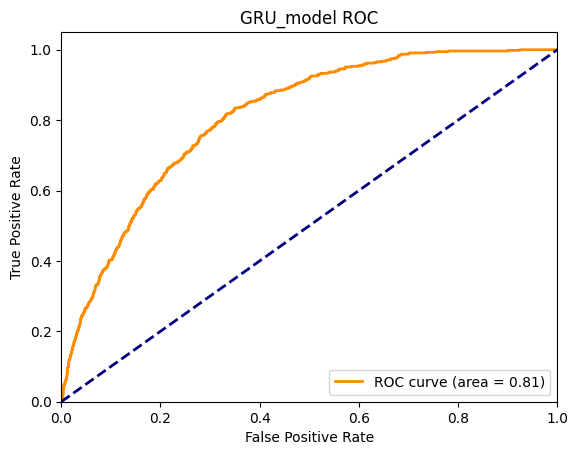

Bi_GRU_model.pth results:
AUC: 0.8756708233319672


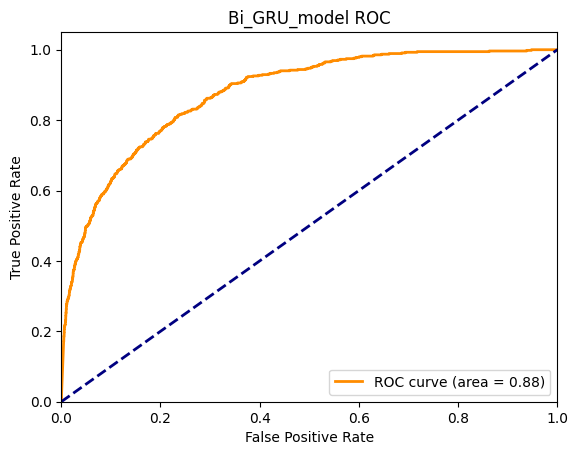

LSTM_model.pth results:
AUC: 0.7225445216100406


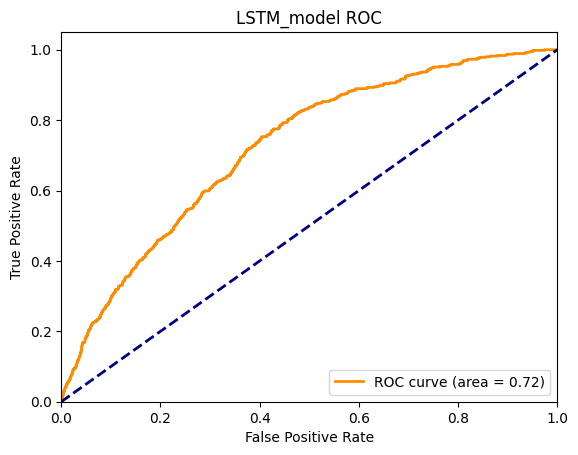

Bi_LSTM_model.pth results:
AUC: 0.8506809212193501


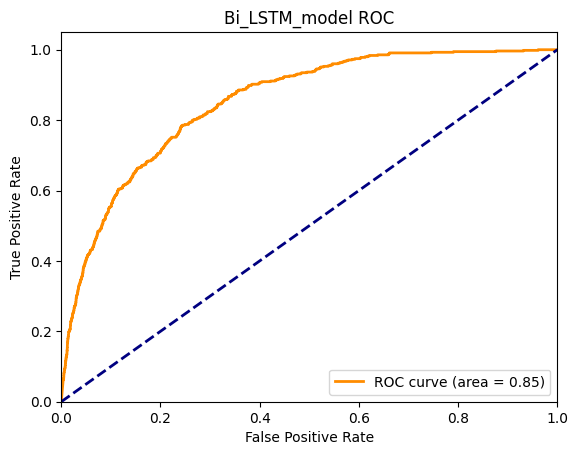

NameError: name 'GlobalMaxPooling1D' is not defined

In [ ]:
# Result

GRU_model = GRUModel(300, 1200, 0.5, 0.001)
create_ROC(GRU_model, "GRU_model.pth", test_seqs, test_labels, virus_data=False)

BiGRU_model = BiGRUModel(300, 1200, 0.5, 0.001)
create_ROC(BiGRU_model, "Bi_GRU_model.pth", test_seqs, test_labels, virus_data=False)

LSTM_model = LSTMModel(300, 1000, 0.5, 0.001)
create_ROC(LSTM_model, "LSTM_model.pth", test_seqs, test_labels, virus_data=False)

Bi_LSTM_model = BiLSTMModel(300, 1200, 0.5, 0.001)
create_ROC(Bi_LSTM_model, "Bi_LSTM_model.pth", test_seqs, test_labels, virus_data=False)

deep_pattern_branch = DeepPatternBranch(300, 1200, 11, 4, 0.1, 0.001)
create_ROC(deep_pattern_branch, "deep_cnn_model.pth", test_seqs, test_labels, virus_data=False)

CNN_LSTM_model = CNNLSTMModel(300, 1000, 8, 0.1)
create_ROC(CNN_LSTM_model, "cnn_lstm_model.pth", test_seqs, test_labels, virus_data=False)

CNN_GRU_model = CNNGRUModel(300, 1000, 8, 0.1)
create_ROC(CNN_GRU_model, "cnn_gru_model.pth", test_seqs, test_labels, virus_data=False)

CNN_BiLSTM_model = CNNBiLSTMModel(300, 1000, 8, 0.1)
create_ROC(CNN_BiLSTM_model, "cnn_bilstm_model.pth", test_seqs, test_labels, virus_data=False)

cnn_bigru_model = CNNBiGRUModel(300, 1000, 8, 0.1)
create_ROC(cnn_bigru_model, "cnn_bigru_model.pth", test_seqs, test_labels, virus_data=False)

